# Marlow Case - TripleTen DS Course - Sprint 14 Project: #
# Sentiment Classification of IMDB Movie Reviews for Automated Content Moderation #
___________________________________________________________________________________________________________________________________________________________

# Table of Contents #
<a id='contents'></a>

- [1. Introduction](#intro)
    - [Imports & Initializations](#import)
- [2. Data Exploration and Preprocessing](#EProc)
- [3. Exploratory Data Analysis](#EDA)
    - [3.1 Number of Movies & Reviews per Year](#per_year)
    - [3.2 Distribution of Number of Reviews per Movie](#num_review)
    - [3.3 Top 10 Genres](#genres)
    - [3.4 Rating Distribution Comparison: Train vs. Test Sets](#rating_dist)
    - [3.5 Number of Reviews Distribution Comparison: Train vs. Test Sets](#num_train_test)
    - [3.6 Distribution of Target Classes](#targets)
- [4. Model Preparation](#m_prep)
    - [4.1 Normalization](#normy)
    - [4.2 Dataset Segmentation](#splits)
- [5. Model Development](#mods)
    - [5.1 Model 0 - Constant](#dummy)
    - [5.2 Model 1 - NLTK, TF-IDF, and LogR](#nltklr)
    - [5.3 Model 2 - NLTK, TF-IDF, and LightGBM](#nltk_lgbm)
    - [5.4 Model 3 - spaCy, TF-IDF, and LogR](#spa-idf)
    - [5.5 Model 4 - spaCy, TF-IDF, and LightGBM](#model4)
    - [5.6 Model 5 - BERT LogR](#model5)
    - [5.7 Model 6 - BERT LightGBM](#model6)
    - [5.8 Final Results](#final)
- [6. Custom Reviews](#reviews)
- [7. Conclusion](#conclusion)
- [Appendix A: Saving Models](#appendix_a)

# 1. Introduction
<a id='intro'></a>
_________________________________________________________________________________________________________________________________________________________

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system to automatically categoirze movie reviews, helping classic movie enthusiasts quickly identify and engage with diverse perspectives on their beloved films. 

## Purpose ##

To build a high-performing classification model that accurately detects negative reviews **with an F1 score of at least 0.85,** enhancing the community's content moderation and streamlining the review filtering process. 

## Imports & Initializations ##
<a id='import'></a>

In [1]:
import pandas as pd
import numpy as np
import math
import time
import re

from joblib import dump, load

# Progress Bar
from tqdm.auto import tqdm

# Visualizations
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ML metrics
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Text preprocessing in NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# spaCy
import spacy

# BERT
import torch
import transformers

# ML models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load saved models
variable_mapping = {
    'Dummy Constant': 'dummy',
    'NLTK-IDF-LogR': 'logr_search',
    'NLTK-IDF-LGBM': 'lgbm_opt',
    'Spacy-IDF-LogR': 'slogr_opt',
    'Spacy-IDF-LGBM': 'slgbm_opt',
    'BERT-LogR': 'blogr_opt',
    'BERT-LGBM': 'blgbm_opt'
}

# load models and assign original variable name
for filename, var_name in variable_mapping.items():
    globals()[var_name] = load(f"{filename}.joblib")
    print(f"Successfully loaded {filename}.")

#best_model = load('best_model_dict.joblib')

Successfully loaded Dummy Constant.
Successfully loaded NLTK-IDF-LogR.
Successfully loaded NLTK-IDF-LGBM.
Successfully loaded Spacy-IDF-LogR.
Successfully loaded Spacy-IDF-LGBM.


In [3]:
# Configure matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
# Enable progress bar
tqdm.pandas()

[Back to Contents](#contents)

# 2. Data Exploration & Preprocessing #
<a id='EProc'></a>
_________________________________________________________________________________________________________________________________________________________

In [5]:
# load the dataset
filepath = r"C:\Users\marlo\OneDrive\Desktop\Python_Work\Tripleten_Lessons\Sprint_14_Project"

try:
    data = pd.read_csv(f"{filepath}\\imdb_reviews.tsv", sep = '\t')
except:
    data = pd.read_csv("/datasets/imdb_reviews.tsv", sep = '\t')

In [6]:
data.shape

(47331, 17)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

According to the info statement, the columns are all filled, but we will check the unique values in the dataset incase missing or anomalous values are represented in other ways. With each column being filled, those representations should be obvious.

We are only concerned with the `review` and `pos` columns as the training set will only include the `review` column, no other missing/anomalous values will need to be addressed. 

Only other item to note is that the `votes` column is a float and can be converted to int. 

In [8]:
# convert votes to in
data['votes'] = data['votes'].astype('Int64')
data.dtypes

tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes                Int64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object

In [9]:
data.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

Column formatting is good. No corrections necessary. 

## Data Description ##

*The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). **Learning Word Vectors for Sentiment Analysis.** The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).*

Here's an inferred description of the data provided:

**_Features_**
- `tconst`: A unique identifier for each title; links each entry to a specific movie, show, or episode.
- `title_type`: The type or category indicating the kind of media. (_movie, short, tvSeries, tvEpisode, etc_)
- `primary_title`: The main or common title of the media as it is generally known or advertised.
- `original_title`: The original title of the media.
- `start_year`: The year the media was first released or aired.
- `end_year`: For TV series, the year the media ended, or year of final airing.
- `runtime_minutes`: The duration of the media in minutes. Total runtime for movies, or average episode runtime for TV series.
- `is_adult`: Flag field indicating if the media is intended for adult audiences (e.g., rated 18+). 1 means yes.
- `genres`: The genre associated with the media entry.
- `average_rating`: The average user rating for the title on a scale from 1-10.
- `votes`: The total number of votes, or user reviews, submitted by users for this title.
- **`review`:** The text of a user review for the media.
- `rating`: The rating given to the media by the user during review.
- `sp`: Sentiment polarity; essentially a string-flag indicator for positive or negative review
- `ds_part`: Specifies the data split, such as "train" or "test". Used for splitting the data.
- `idx`: An identifier for the data point in the dataset.

**_Target_**
- `pos`: Represents the sentiment polarity as an integer for positive reviews. 1 means positive review.

## Implicit Values ##

In [10]:
# observe distinct values
cols_to_observe = ['title_type', 'start_year', 'end_year', 'average_rating', 'rating', 'sp', 'pos', 'ds_part']

for col in data.columns:
    if col in cols_to_observe:
        print(f"Unique values in {col}: \n")
        print(data[col].unique())
        print("--" * 35)

Unique values in title_type: 

['movie' 'short' 'tvEpisode' 'video' 'tvMovie' 'tvSpecial' 'tvSeries'
 'tvMiniSeries' 'videoGame' 'tvShort']
----------------------------------------------------------------------
Unique values in start_year: 

[1971 2002 1943 2001 1975 1997 1986 1994 2005 2006 2000 2004 1995 1998
 2007 2003 1972 1977 1984 1968 1991 1992 1959 1988 1956 1999 2009 1980
 1983 1915 1908 1990 1996 1903 1987 1985 2008 1948 1941 1989 1937 1982
 1978 1947 1936 1957 1917 1954 1934 1970 1946 1979 1930 1926 1935 1933
 1966 1976 1945 1981 1918 1974 1942 1938 1951 1993 1924 1952 1953 1973
 1912 1949 1969 1940 1950 1958 1960 1955 1939 1929 1967 1932 1961 1965
 1913 1925 1931 1927 1944 2010 1920 1894 1919 1922 1923 1914 1921 1964
 1962 1910 1902 1928 1895 1963 1916 1909 1897]
----------------------------------------------------------------------
Unique values in end_year: 

['\\N' '1999' '2008' '2005' '1987' '1981' '1990' '2009' '1985' '1986'
 '2004' '2002' '1994' '2007' '1996' '1960' '

In [11]:
# check end_year
null_ends = data[data['end_year'] != '\\N'].head()
null_ends

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
325,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,No rubbish - no where even near rubbish. Not a...,8,pos,1,train,2496
326,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"A weird, witty and wonderful depiction of fami...",9,pos,1,train,2495
327,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"Typical 90's comedy, situational comedy simila...",10,pos,1,train,2493
328,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,This first two seasons of this comedy series w...,10,pos,1,train,2494
340,tt0437696,tvSeries,30 Days,30 Days,2005,2008,60,0,"Documentary,Reality-TV",7.9,1876,This video has audio that is meant for someone...,1,neg,0,test,4013


In [12]:
null_ends['end_year'].unique()

array(['1999', '2008'], dtype=object)

In [13]:
# check null in average_rating
data[data['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


**_Notes on Unique Analysis_**
- The different categories in `title_type` are interesting, but no further analysis is necessary as there is nothing anomalous and the instructions do not state that reviews must strictly be for movies.
- No anomalous values in `start_year`.
- Null values exist in the `end_year` due to this field only applying to TV series related title types. This would technically cause issues in graphing, but not for our purposes, and we could also work around it if needed, as there are no nulls in the tv series entries.
- `average_rating` does contain nulls, these are not relevant to our project so we will leave in the dataset.
- The remaining columns checked all looked good. No actions necessary.

We are more concerned with missing or anomalous values in the `review` column or the target column.

In [14]:
# check target
data.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [15]:
data['pos'].unique()

array([0, 1], dtype=int64)

Having null in votes is likely an entry error, but not relevant to our data so no need to correct. The target column contains no actual or implicit null values. Let's check the reviews. 

In [16]:
# establish categorical variables
cat_cols = []

for col in data.columns:
    if data[col].dtype == 'object':
        cat_cols.append(col)

# Observe describe
data[cat_cols].describe()

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0067445,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


Out of 47,331 reviews, 47,240 of them are unique. Let's investigate this. 

In [17]:
dup_reviews = data[data['review'].duplicated(keep = False)]
display(dup_reviews['review'].head(10))
print('--' * 30)

1368    I have seen this film at least 100 times and I...
1370    I have seen this film at least 100 times and I...
1629    THE JIST: See something else. This film was hi...
1630    THE JIST: See something else. This film was hi...
1753    I used to watch this show when I was a little ...
1982    This movie is very scary with scenes where the...
1983    This movie is very scary with scenes where the...
2130    I saw this in the summer of 1990. I'm still an...
2132    I saw this in the summer of 1990. I'm still an...
2235    This is an Emperor's New Clothes situation. So...
Name: review, dtype: object

------------------------------------------------------------


There are certainly duplicate values among the reviews and therefore we will remove these instances. 

Let's confirm there are no reviews that are close to blank by only having a few characters and could therefore not be useful in determining sentiment. 

In [18]:
data.drop_duplicates(subset = ['review'], inplace = True)
data['review'].duplicated().sum()

0

In [19]:
short_reviews = data[data['review'].str.len() < 10]
short_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx


[Back to Contents](#contents)

# 3. Exploratory Data Analysis #
<a id='EDA'></a>
_________________________________________________________________________________________________________________________________________________________

## 3.1 Number of Movies & Reviews per Year ##
<a id = 'per_year'></a>

In [20]:
# Prepare the data
# Number of unique movies per year
df_t1 = data[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
df_t1 = df_t1.reindex(index = np.arange(df_t1.index.min(), max(df_t1.index.max(), 2021))).fillna(0)

# Number of reviews (pos and neg) per year
df_t2 = data.groupby(['start_year', 'sp'])['sp'].count().unstack()
df_t2 = df_t2.reindex(index = np.arange(df_t2.index.min(), max(df_t2.index.max(), 2021))).fillna(0)

# Five-year rolling mean
df_t3 = data['start_year'].value_counts().sort_index()
df_t3 = df_t3.reindex(index = np.arange(df_t3.index.min(), max(df_t3.index.max(), 2021))).fillna(0)
df_t3 = (df_t3 / df_t1).fillna(0) # avg num of reviews per year
df_t3 = df_t3.reset_index(drop = True).rolling(5).mean()

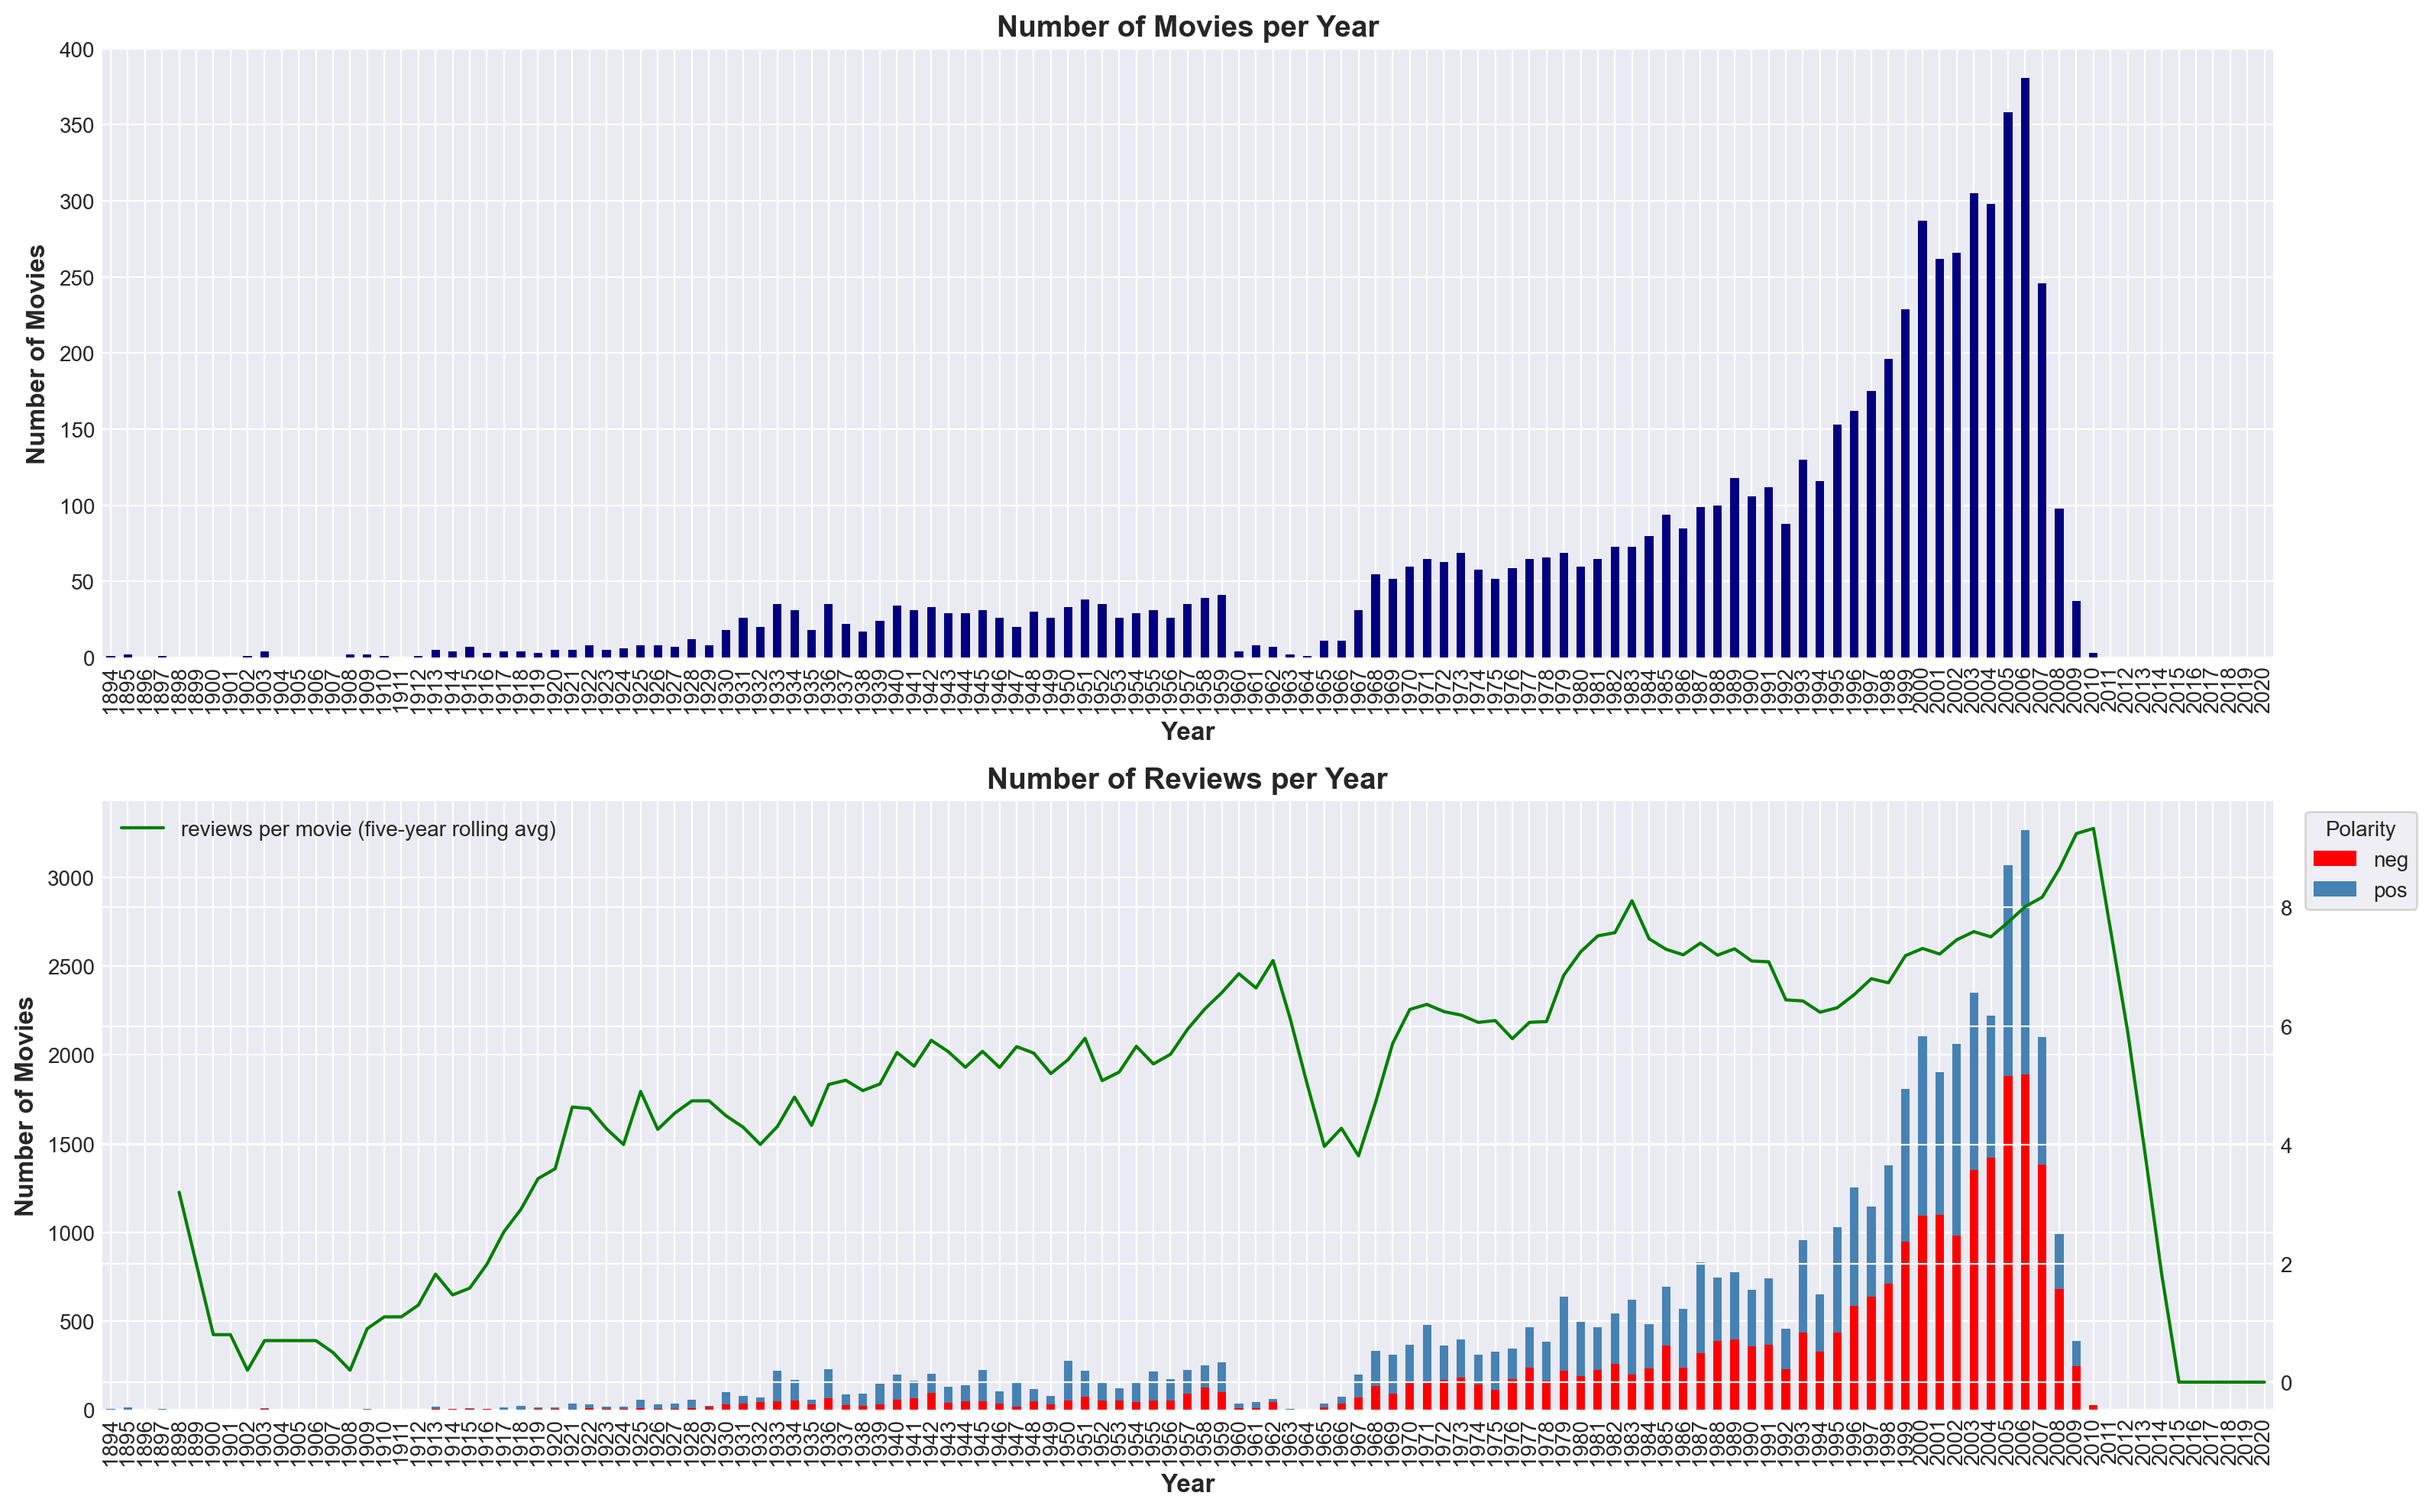

In [21]:
# plot graph
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (16,10))

ax = axs[0]
df_t1.plot(kind = 'bar', ax = ax, color = 'navy')
ax.set_title("Number of Movies per Year", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Year", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Number of Movies", fontsize = 12, fontweight = 'bold')

ax = axs[1]
df_t2.plot(kind = 'bar', stacked = True, ax = ax, color = ['red', 'steelblue'])
ax.set_title("Number of Reviews per Year", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Year", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Number of Movies", fontsize = 12, fontweight = 'bold')
ax.legend(title = 'Polarity', loc = 'upper left', frameon = True, bbox_to_anchor = (1.01,1))
ax = axs[1].twinx()

df_t3.plot(color = 'green', label = "reviews per movie (five-year rolling avg)", ax = ax)
ax.legend(loc = 'upper left')

fig.tight_layout()
plt.show()

**_Notes_**
- The number of movies remained on a steady trend of less than 50 until 1968, and then the number of unique movies per year increased 1992. Afterwards there was almost epontential growth in the number of movies until 2006.
- We can observe an identical trend in the number of reviews per year.
- Starting in the 1990s, there is an increasing trend in the amount of negative reviews.

[Back to Contents](#contents)

## 3.2 Distribution of Number of Reviews per Movie ##
<a id='num_review'></a>

In [22]:
# Prepare the data
# Num of reviews per movie
df_t1 = data.groupby('tconst')['review'].count()

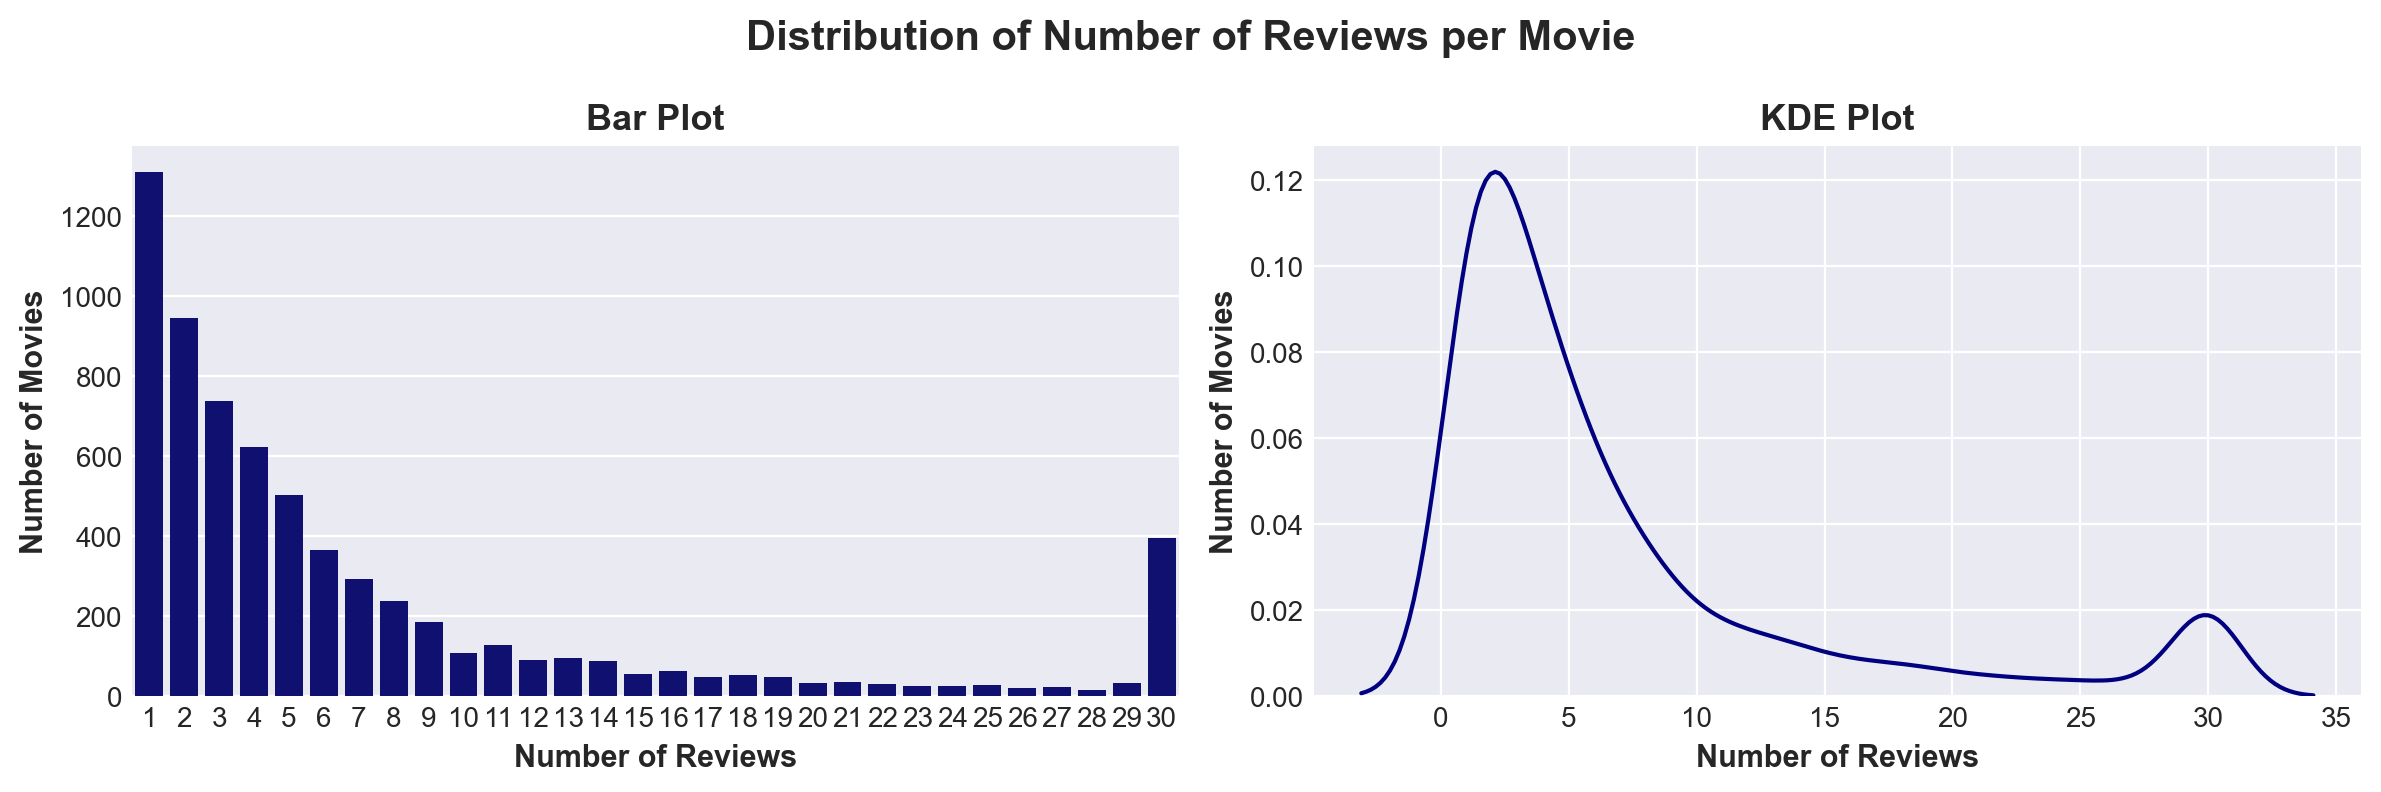

In [23]:
# plot the bar chart
fig, axs = plt.subplots(1, 2, figsize = (12,4))

fig.suptitle("Distribution of Number of Reviews per Movie", fontsize = 15, fontweight = 'bold')

ax = axs[0]
sns.countplot(x = df_t1.values, ax = ax, color = 'navy')
ax.set_title("Bar Plot", fontsize = 13, fontweight = 'bold')
ax.set_xlabel("Number of Reviews", fontsize = 11, fontweight = 'bold')
ax.set_ylabel("Number of Movies", fontsize = 11, fontweight = 'bold')

ax = axs[1]
sns.kdeplot(df_t1, ax=ax, color = 'navy')
ax.set_title("KDE Plot", fontsize = 13, fontweight = 'bold')
ax.set_xlabel("Number of Reviews", fontsize = 11, fontweight = 'bold')
ax.set_ylabel("Number of Movies", fontsize = 11, fontweight = 'bold')

fig.tight_layout()
plt.show()

 Most movies have less than 10 reviews, except for a spike at 30 reviews. This spike is likely from movies with greater than 30 reviews being lumped together at 30, based on the distribution, but if not than that would be an interesting and surprising spike. We are unable to confirm this from the provided information on the dataset. 

 [Back to Contents](#contents)

## 3.3 Top 10 Genres ##
<a id='genres'></a>

In [24]:
# Break down the genres column
df_t1 = data.copy()
df_t1['genres'] = df_t1['genres'].str.split(',')
df_t2 = df_t1[['genres', 'sp']].explode('genres').groupby('genres')['sp'].value_counts().unstack()
df_t2.head(3)

sp,neg,pos
genres,,
Action,5256,3386
Adult,32,39
Adventure,3040,2770


In [25]:
# create totals and sort
df_t2['total'] = df_t2['neg'] + df_t2['pos']
df_t2 = df_t2.sort_values(by = 'total', ascending = False).head(10)
df_t2

sp,neg,pos,total
genres,,,
Drama,9658,12632,22290
Comedy,7071,8037,15108
Action,5256,3386,8642
Horror,6035,2480,8515
Romance,3346,4114,7460
Crime,3387,3694,7081
Thriller,4010,2809,6819
Adventure,3040,2770,5810
Fantasy,1995,1923,3918


In [26]:
# Avg user rating in top genres
df_t3 = df_t1[['genres', 'rating', 'sp']].explode('genres').pivot_table(
    index = 'genres',
    columns = 'sp',
    values = 'rating',
    aggfunc = 'mean'
)
df_t3 = df_t3.reindex(df_t2.index)
df_t3

sp,neg,pos
genres,,
Drama,2.295713,8.781270
Comedy,2.171404,8.762598
Action,2.151256,8.679268
Horror,2.191549,8.517339
Romance,2.353258,8.710501
Crime,2.304990,8.605847
Thriller,2.244888,8.559986
Adventure,2.173355,8.867509
Fantasy,2.229073,8.731149


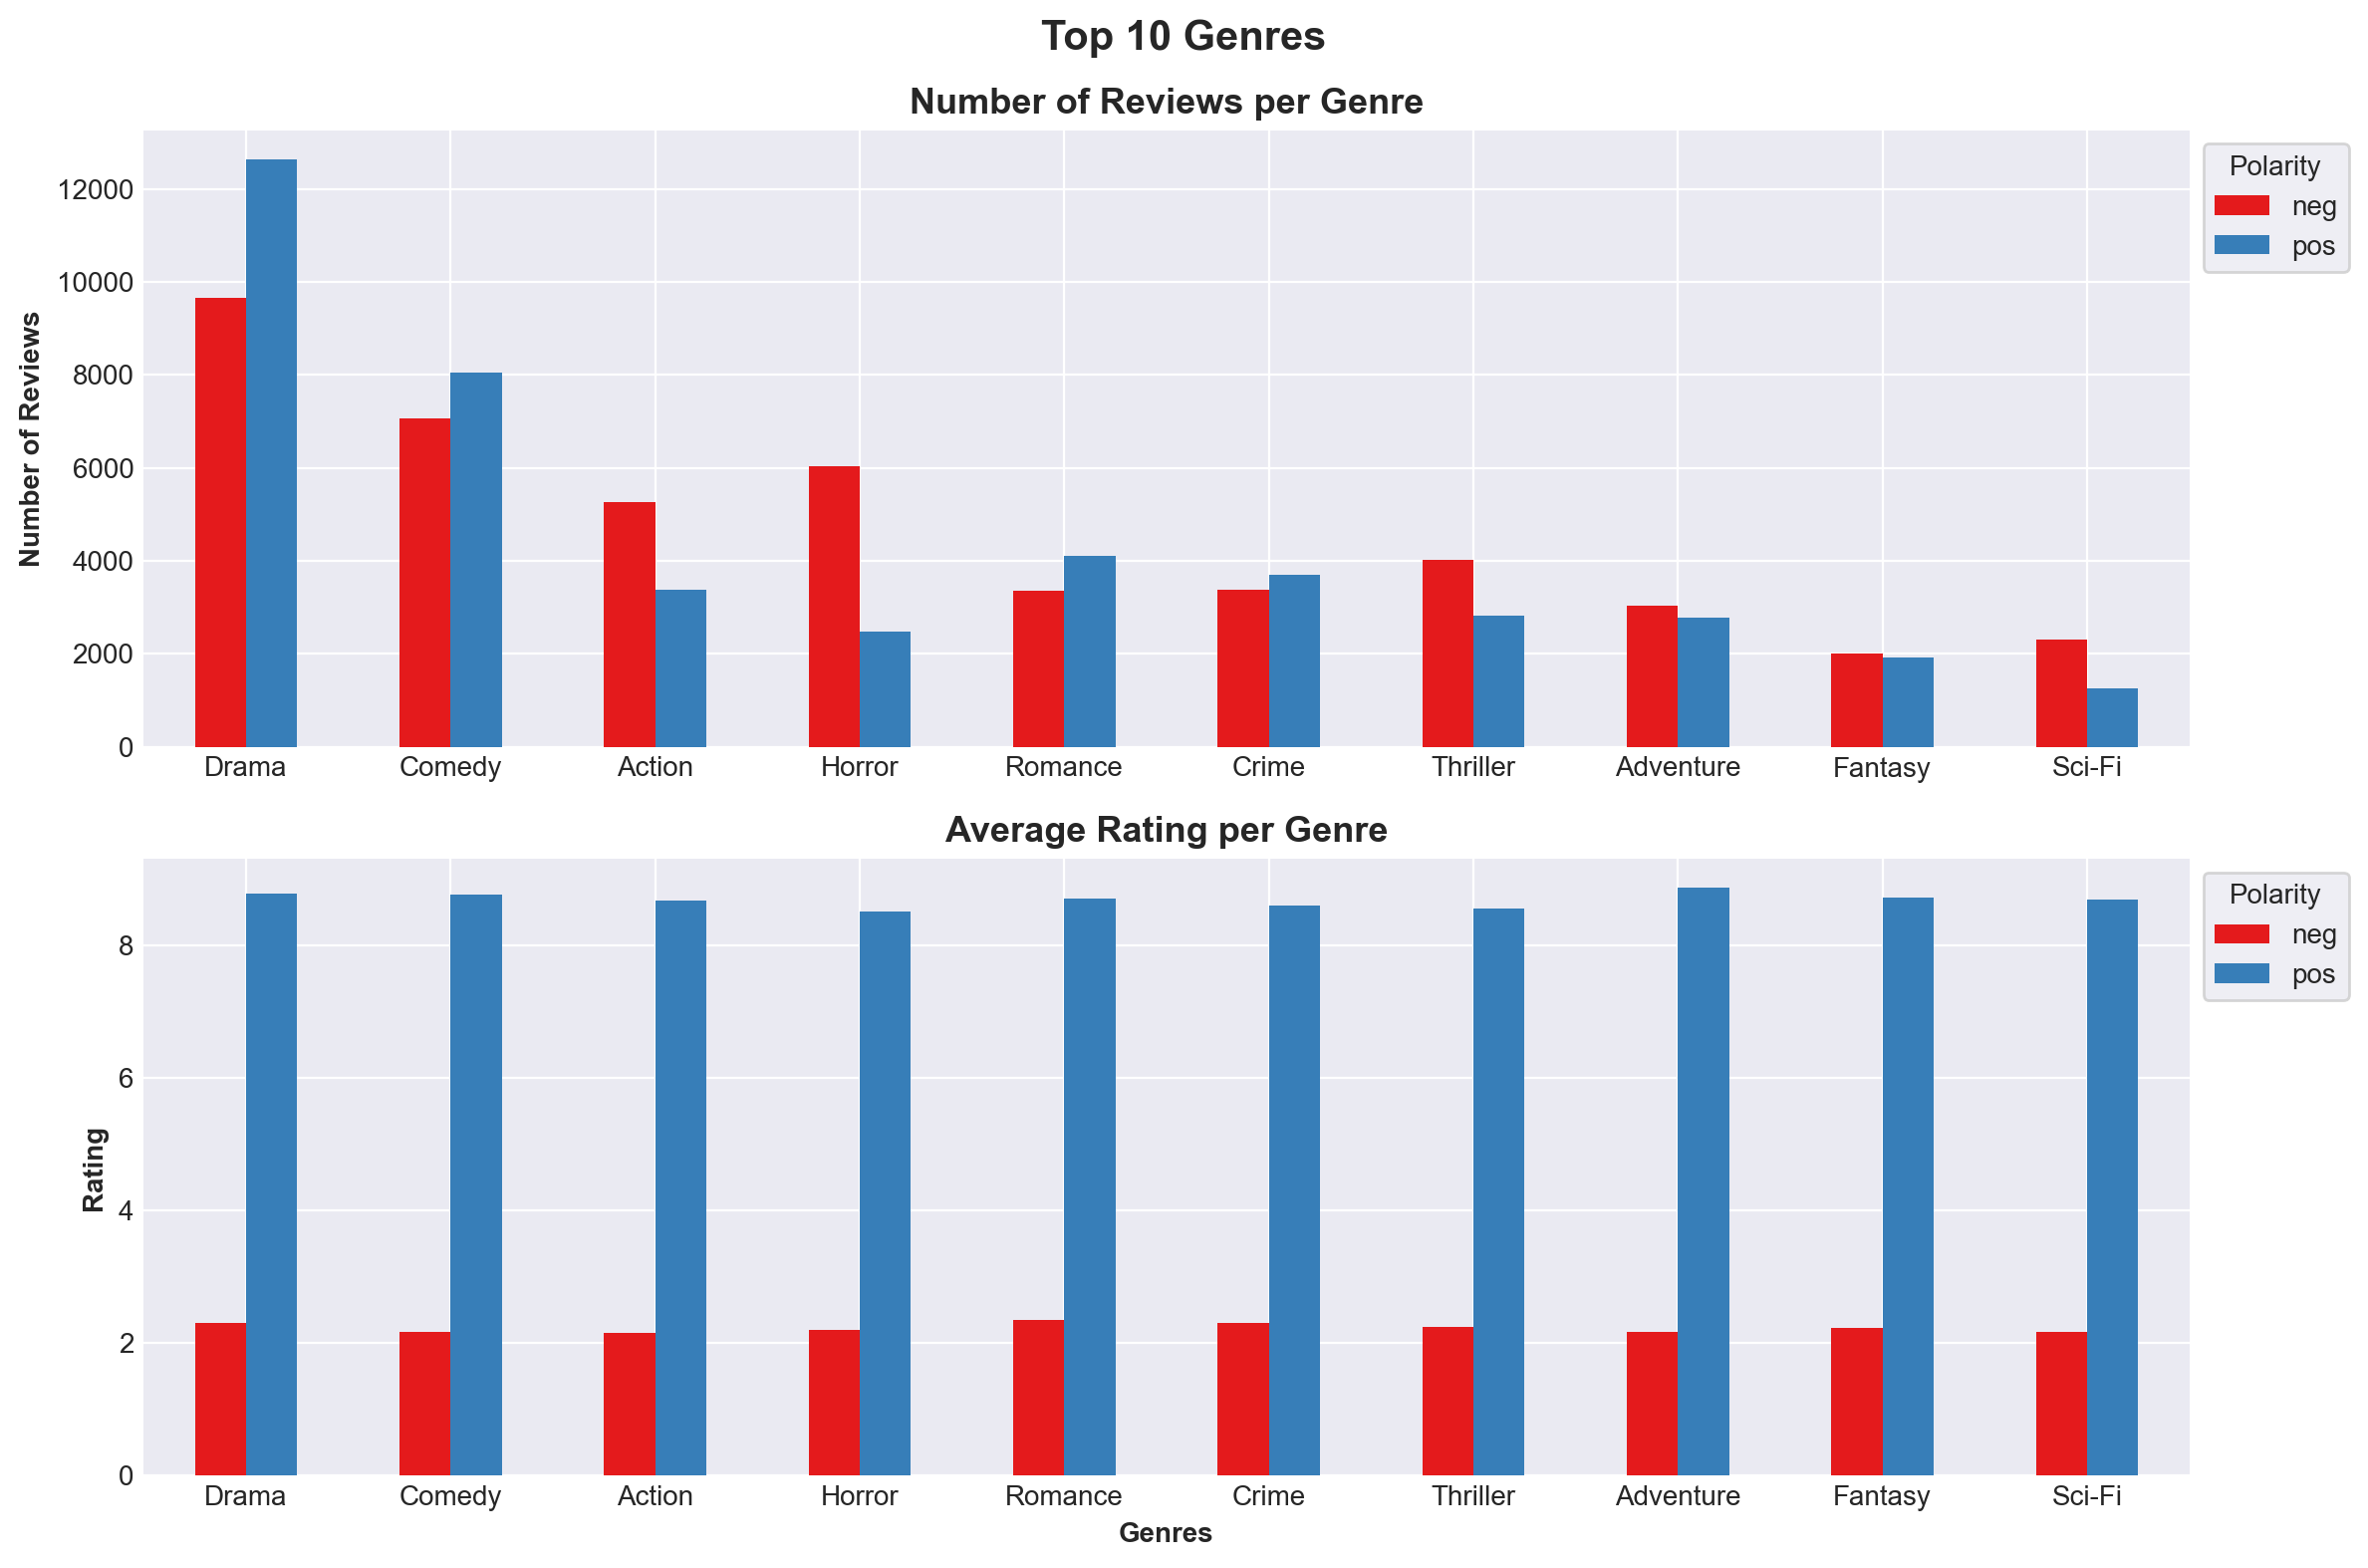

In [27]:
# plot the bar charts
sns.set_palette("Set1")
fig, axs = plt.subplots(2, 1, figsize = (12, 8))

fig.suptitle("Top 10 Genres", fontsize = 15, fontweight = 'bold')

ax = axs[0]
df_t2.plot(kind = 'bar', y = ['neg', 'pos'], ax=ax)
ax.set_title("Number of Reviews per Genre", fontsize = 13, fontweight = 'bold')
ax.set_xlabel("", fontweight = 'bold')
ax.set_ylabel("Number of Reviews", fontweight = 'bold')

ax = axs[1]
df_t3.plot(kind = 'bar', y = ['neg', 'pos'], ax=ax)
ax.set_title("Average Rating per Genre", fontsize = 13, fontweight = 'bold')
ax.set_xlabel("Genres", fontweight = 'bold')
ax.set_ylabel("Rating", fontweight = 'bold')

# Rotate x-axis labels and legend
plt.setp([ax.get_xticklabels() for ax in fig.get_axes()], rotation=0)

[ax.legend(
    title = 'Polarity', loc = 'upper left', bbox_to_anchor = (1,1), frameon=True
) for ax in fig.get_axes()]

plt.tight_layout()
plt.show()

**_Notes_**
- Drama and Comedy are the most popular genres by a decent margin.
- Horror movies have the largest ratio of negative reviews to postive reviews.
- Action, Thriller, Horror, and Sci-Fi genres all have more negative reviews than positive.
- Movies with more positive reviews have higher ratings.

[Back to Contents](#contents)

## 3.4 Rating Distribution Comparison: Train vs. Test Sets ##
<a id='rating_dist'></a>

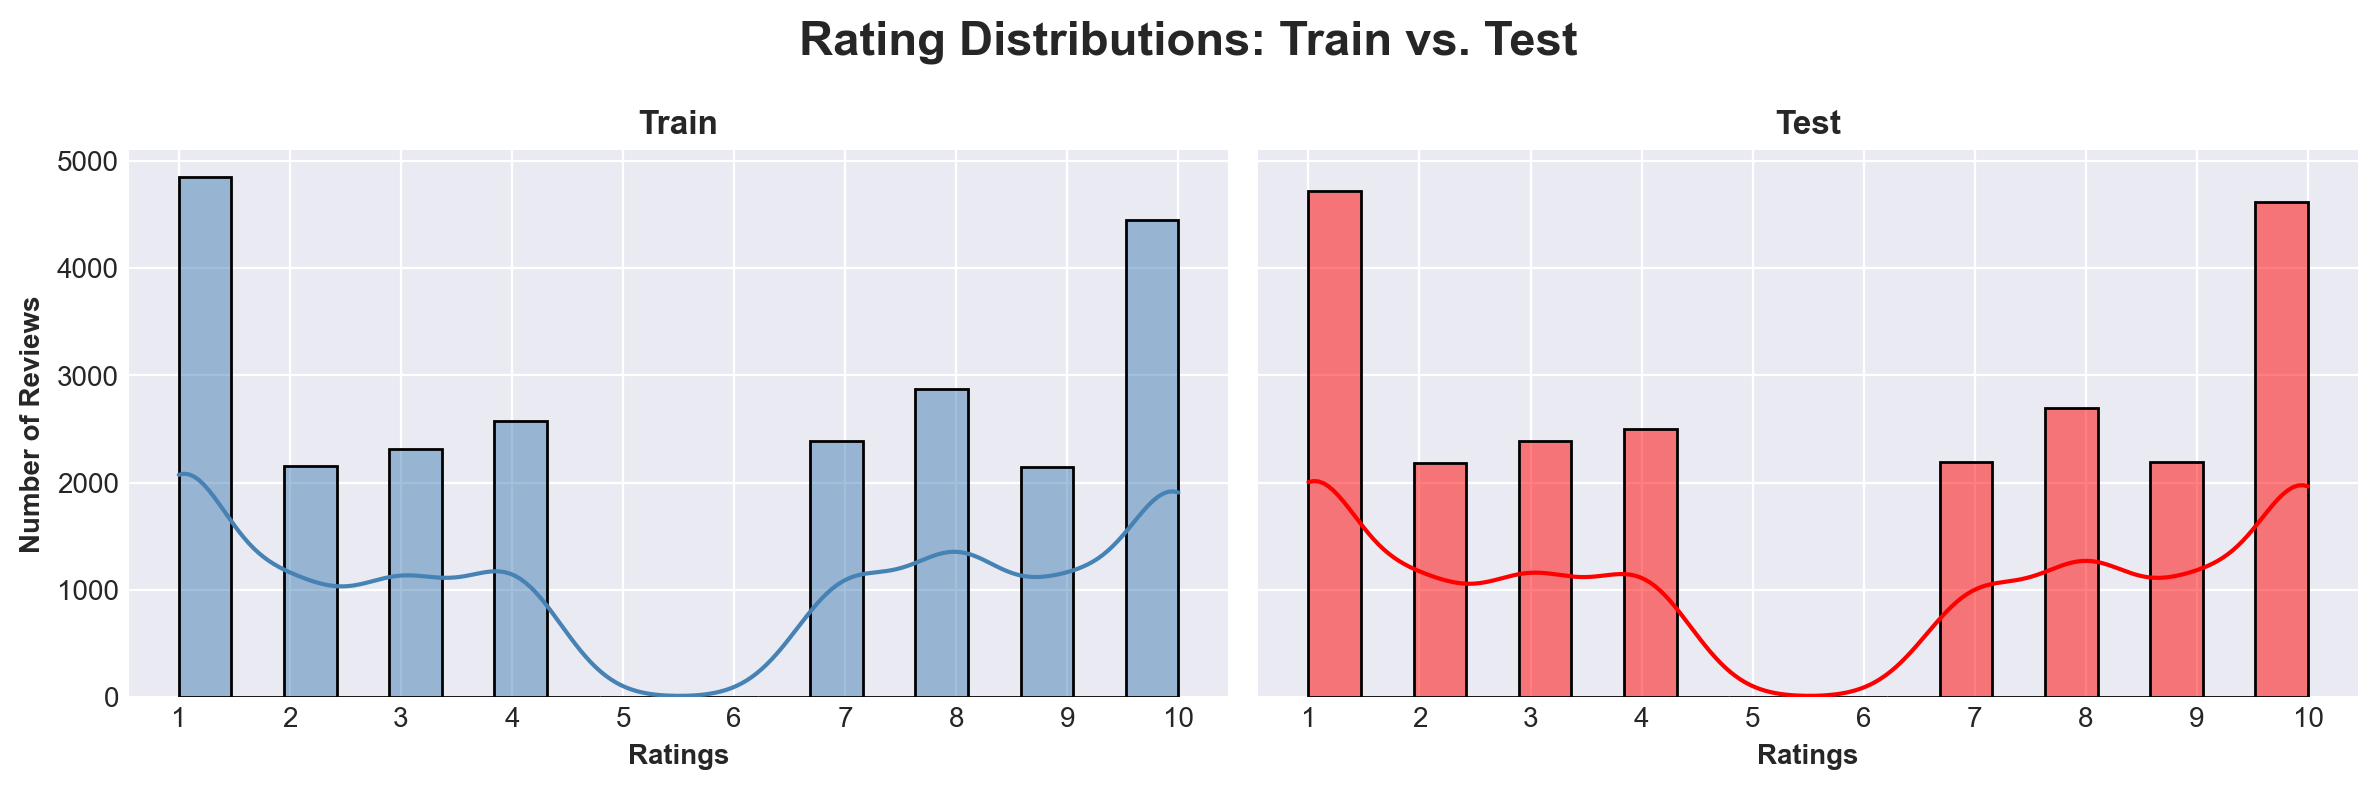

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharey = True)

fig.suptitle("Rating Distributions: Train vs. Test", fontsize = 17, fontweight = 'bold')

ax = axs[0]
sns.histplot(
    data = data.query("ds_part == 'train'"),
    x = 'rating', color = 'steelblue', ax = axs[0], kde = True)

ax.set_title("Train", fontsize = 12, fontweight = 'bold')
ax.set_xlabel("Ratings", fontweight = 'bold')
ax.set_ylabel("Number of Reviews", fontweight = 'bold')
ax.set_xticks(range(1,11))

ax = axs[1]
sns.histplot(
    data = data.query("ds_part == 'test'"),
    x = 'rating', color = 'red', ax = axs[1], kde = True
)
ax.set_title("Test", fontsize = 12, fontweight = 'bold')
ax.set_xlabel("Ratings", fontweight = 'bold')
ax.set_ylabel("", fontweight = 'bold')
ax.set_xticks(range(1,11))

plt.tight_layout()
plt.show()

**_Notes:_**
- The distributions of the Train and Test sets are identical, which will be perfect for effective machine learning models.
- There are no reviews with a rating of 5 or 6; perhaps users feel 5 and 6 are non answers and not useful to others reading their review.

[Back to Contents](#contents)

## 3.5 Number of Reviews Distribution Comparison: Train vs. Test Sets ##
<a id='num_train_test'></a>

In [29]:
# Prepare the data
# Number of reviews per movie: train and test
df_t1 = data.pivot_table(
    index = 'tconst',
    columns = ['ds_part', 'sp'],
    values = 'votes',
    aggfunc = 'count'
)
df_t1.head(3)

ds_part    test       train      
sp          neg   pos   neg   pos
tconst                           
tt0000010  <NA>  <NA>  <NA>    11
tt0000030  <NA>     1  <NA>  <NA>
tt0000208  <NA>     4  <NA>  <NA>

In [30]:
# Number of reviews per year: train and test
df_t2 = data.pivot_table(
    index = 'start_year',
    columns = ['ds_part', 'sp'],
    values = 'votes',
    aggfunc = 'count'
)

# reindex
df_t2 = df_t2.reindex(index = np.arange(
    df_t2.index.min(), max(df_t2.index.max(), 2020)
)).fillna(0)

df_t2.head(3)

ds_part    test     train    
sp          neg pos   neg pos
start_year                   
1894          1   5     0   0
1895          0   1     0  11
1896          0   0     0   0

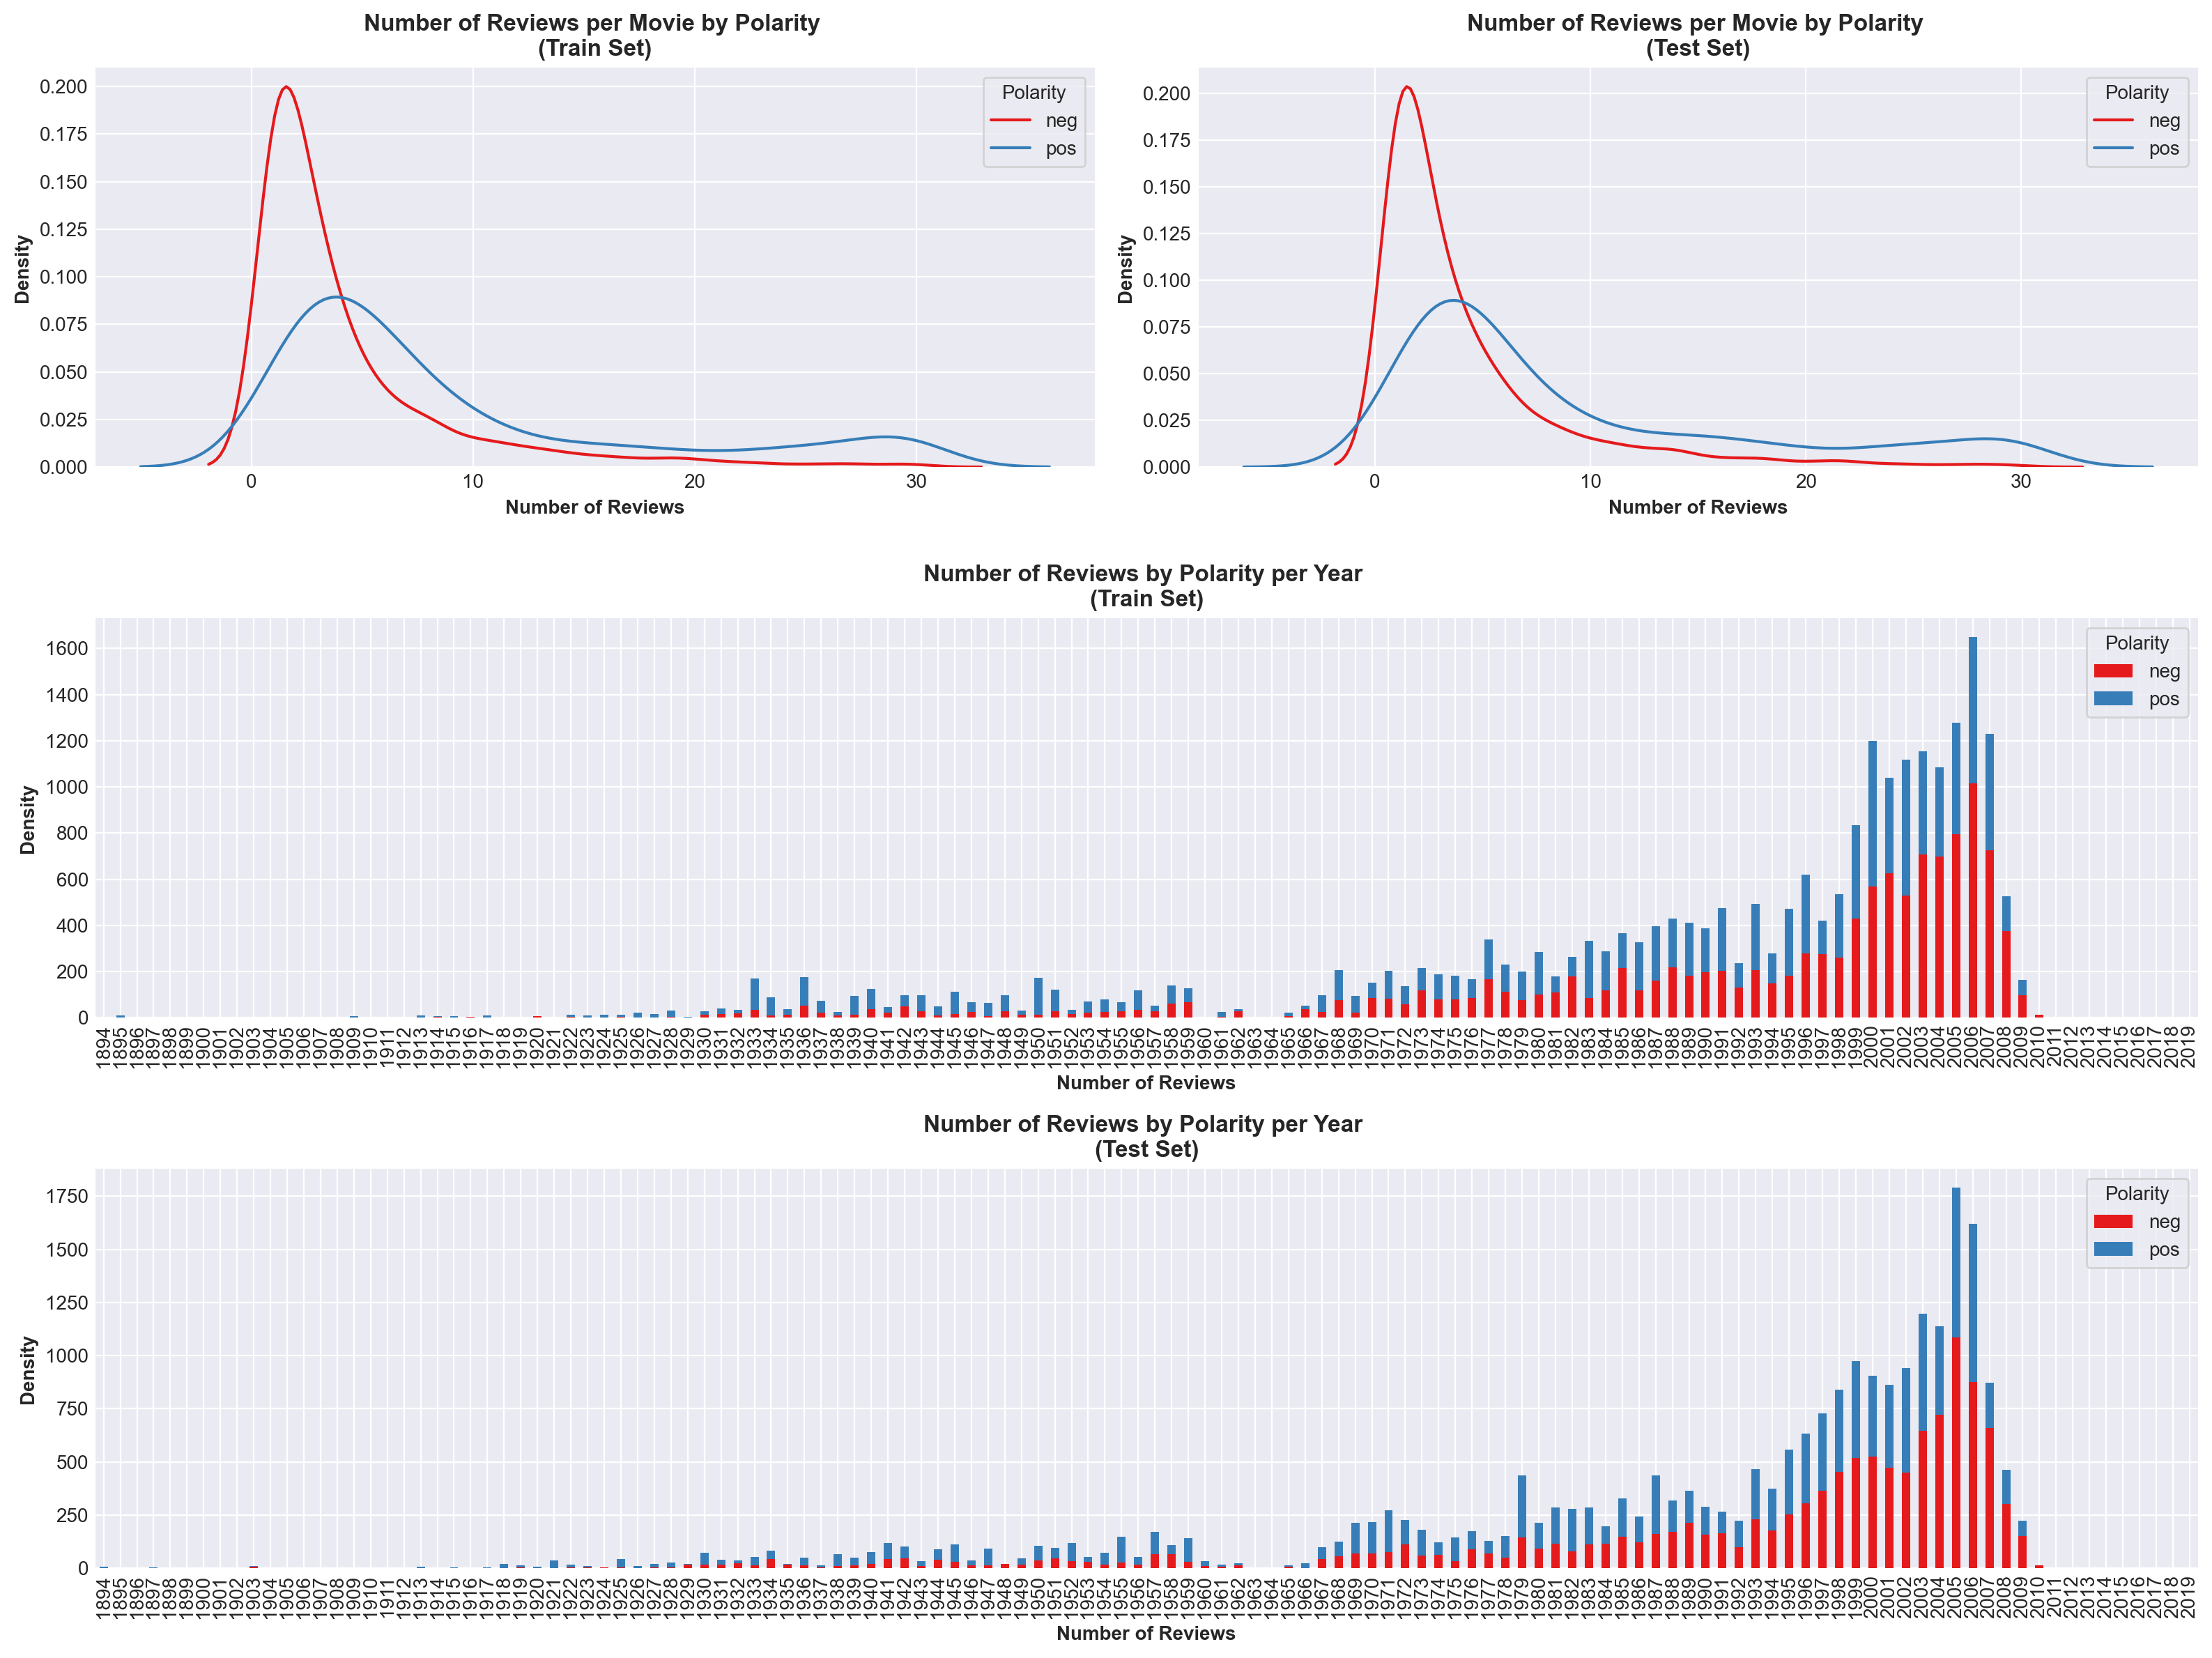

In [31]:
# Plot the data
# Set up figure - mosaic
layout = '''
    ab
    cc
    dd
'''
sns.set_palette("Set1")
fig, axl = plt.subplot_mosaic(layout, figsize = (16, 12))

# KDE plots
ax = axl['a']
sns.kdeplot(data = df_t1['train']['neg'], ax = ax, label = 'neg')
sns.kdeplot(data = df_t1['train']['pos'], ax = ax, label = 'pos')
ax.set_title("Number of Reviews per Movie by Polarity \n(Train Set)", fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title = 'Polarity', frameon = True)

ax = axl['b']
sns.kdeplot(data = df_t1['test']['neg'], ax = ax, label = 'neg')
sns.kdeplot(data = df_t1['test']['pos'], ax = ax, label = 'pos')
ax.set_title("Number of Reviews per Movie by Polarity \n(Test Set)", fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title = 'Polarity', frameon = True)

# Bar plots
ax = axl['c']
df_t2['train'].plot(kind = 'bar', stacked = True, ax = ax)
ax.set_title("Number of Reviews by Polarity per Year \n(Train Set)", fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title = 'Polarity', frameon = True)

ax = axl['d']
df_t2['test'].plot(kind = 'bar', stacked = True, ax = ax)
ax.set_title("Number of Reviews by Polarity per Year \n(Test Set)", fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title = 'Polarity', frameon = True)

plt.tight_layout()
plt.show()

**_Notes:_**

The distributions for the number of reviews per movie and per year between the train and test sets are also very similar. Again, this establishes a stable data environment which is conducive of building effective machine learning models.  

[Back to Contents](#contents)

## 3.6 Distribution of Target Classes ##
<a id='targets'></a>

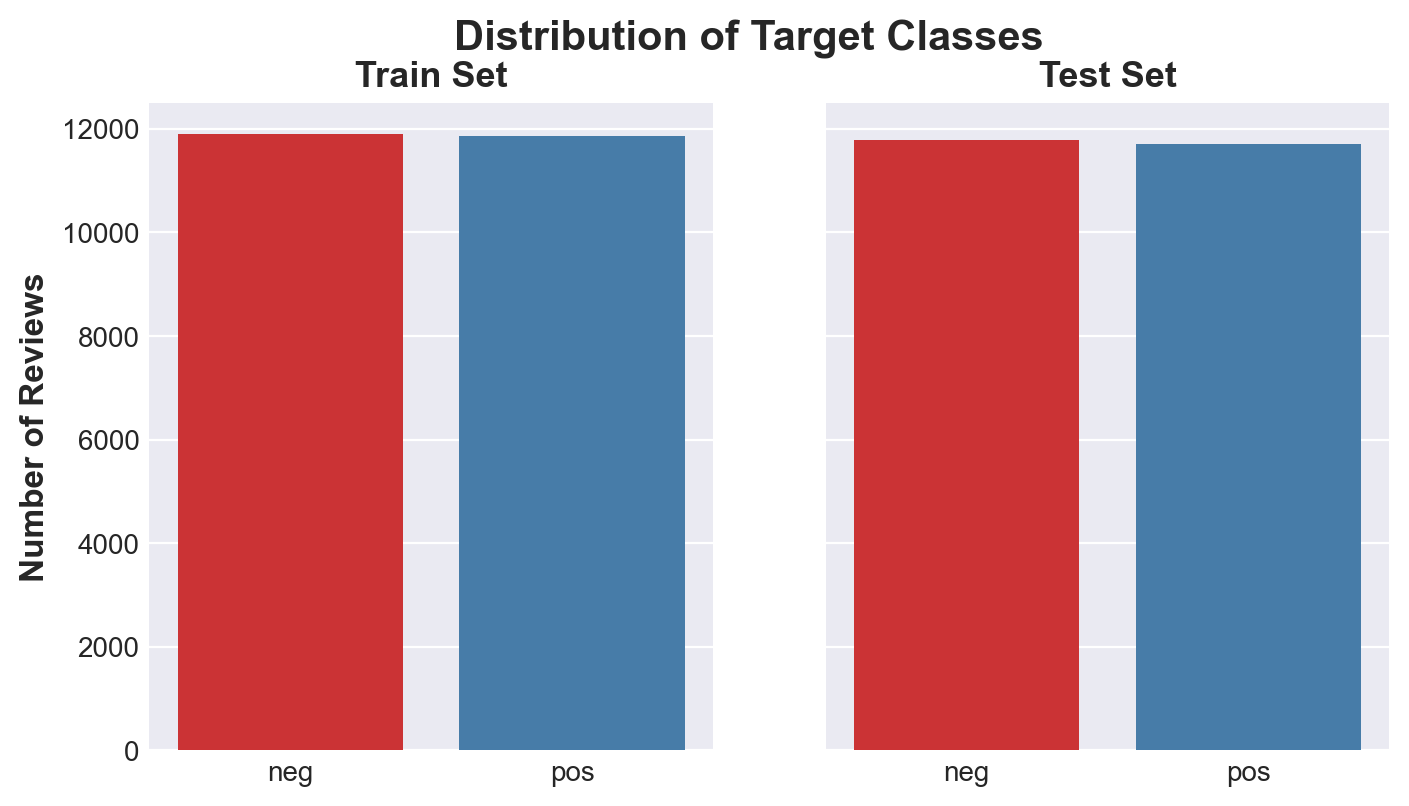

In [32]:
# set up figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4.2), sharey = True)

fig.suptitle("Distribution of Target Classes", fontsize = 15, fontweight = 'bold')

classes = ['train', 'test']

for i, class__ in enumerate(classes):
    sns.countplot(data = data[data['ds_part'] == class__], x = 'sp', hue = 'sp', ax = axs[i])
    axs[i].set_title(f"{class__.title()} Set", fontsize = 13, fontweight = 'bold')
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Number of Reviews", fontsize = 12, fontweight = 'bold')


plt.show()

Class imbalance is not an issue within this dataset. 

[Back to Contents](#contents)

# 4. Model Preparation #
<a id='m_prep'></a>
_________________________________________________________________________________________________________________________________________________________

The function below will aid the tasks in this section. 

In [33]:
def normalize(text):
    '''
    This function normalizes given text by removing 
    digits and punctuation marks, as well as converting
    to lowercase.
    '''
    # lower
    text = text.lower()
    
    # remove digits
    text = re.sub(r"\d+", "", text)
    
    # remove punct
    text = re.sub(r"[^\w\s]", "", text)

    return text

## 4.1 Normalization ##
<a id='normy'></a>

We assume all models below accepts texts in lowercase and without any digits, punctuation marks.

In [34]:
data['review_norm'] = data['review'].progress_apply(normalize)

  0%|          | 0/47240 [00:00<?, ?it/s]

In [35]:
# observe
print("\033[1m" + "Original Text:" + "\033[0m")
print(data['review'].head(3), '\n')

print("\033[1m" + "Normalized Text:" + "\033[0m")
print(data['review_norm'].head(3))

Original Text:
0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
Name: review, dtype: object 

Normalized Text:
0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
Name: review_norm, dtype: object


## 4.2 Dataset Segmentation: Training and Testing Sets ##
<a id='splits'></a>

In [36]:
# split datasets
X_train = data.query("ds_part == 'train'")['review_norm']
y_train = data.query("ds_part == 'train'")['pos']
X_test = data.query("ds_part == 'test'")['review_norm']
y_test = data.query("ds_part == 'test'")['pos']

# observe shapes
split_sets = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

for name, split_set in split_sets.items():
    print(f"Shape of {name}: {split_set.shape}")

Shape of X_train: (23757,)
Shape of X_test: (23483,)
Shape of y_train: (23757,)
Shape of y_test: (23483,)


[Back to Contents](#contents)

# 5. Model Development #
<a id='mods'></a>
_________________________________________________________________________________________________________________________________________________________

The function below serves as a routine which can be used for all models in this project.

In [37]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    '''
    This function evaluate a classification model's performance on both the
    training and test sets. It generates three key plots:
    (F1 Score, ROC Curve, and Precision-Recall Curve)
    and outputs metrics including:
    Accuracy, F1 Score, Avg Precision Score, and ROC AUC.

    How it Works:
    -------------
    1. Initialize: A dictionary (eval_stats) is used to store metrics for 
                   each dataset. 
    2. Create Subplots: Three subplots are displayed: F1, ROC Curve, and
                        and Precision-Recall Curve
    3. Evaluation Loop: For each dataset, the function performs the following:
        - predicts labels and probabilities
        - calcs F1 scores across thresholds 0-1 and finds the max F1 Score
        - Plots the F1 score, ROC Curve, and Precision-Recall Curve while 
            highlighting specific threshold points.
        - Records Accuracy, F1 Score, APS, and ROC AUC in eval_stats
    4. Output: Displays the plots and prints a DataFrame with rounded statistics
               for easy interpretation.
    '''

    # Create eval_stats dict
    eval_stats = {}

    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,7))

    # add baseline in second plot
    axs[1].plot([0,1], [0,1], color = 'grey', linestyle = '--', label = 'base')

    for set, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):

        eval_stats[set] = {}

        y_pred = model.predict(X)
        pred_proba = model.predict_proba(X)[:, 1] #pos class only

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(y, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(y, pred_proba)
        roc_auc = metrics.roc_auc_score(y, pred_proba)
        eval_stats[set]['ROC AUC'] = float(roc_auc)

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(y, pred_proba)
        aps = metrics.average_precision_score(y, pred_proba)
        eval_stats[set]['APS'] = aps

        if set == 'train':
            color = 'steelblue'
        else:
            color = 'red'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
                label=f'{set}, max={f1_scores[max_f1_score_idx]:.4f} @ {f1_thresholds[max_f1_score_idx]:.4f}')
        # Setting crosses for som thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'black' if threshold != 0.5 else 'limegreen'
            ax.plot(
                f1_thresholds[closest_value_idx],
                f1_scores[closest_value_idx],
                color = marker_color,
                marker = 'X', markersize = 7) # end loop
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("threshold", fontweight = 'bold')
        ax.set_ylabel("F1", fontweight = 'bold')
        #if model == loaded_models['Dummy Constant.joblib']:
        if model == dummy:
            ax.legend(loc = 'upper right', frameon = True)
        else:
            ax.legend(loc = 'lower center', frameon = True)
        ax.set_title("F1 Score", fontweight = 'bold')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color = color, label = f"{set}, ROC AUC={roc_auc:.4f}")
        # set crosses
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'black' if threshold != 0.5 else 'limegreen'
            ax.plot(
                fpr[closest_value_idx],
                tpr[closest_value_idx],
                color = marker_color,
                marker = 'X', markersize = 7) # end loop
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR', fontweight = 'bold')
        ax.set_ylabel('TPR', fontweight = 'bold')
        ax.legend(loc='lower center', frameon = True)        
        ax.set_title("ROC Curve", fontweight = 'bold')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color = color, 
                label = f"{set}, AP={aps:.4f}")
        # set crosses
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'black' if threshold != 0.5 else 'limegreen'
            ax.plot(
                recall[closest_value_idx],
                precision[closest_value_idx],
                color = marker_color,
                marker = 'X', markersize = 7) # end loop
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall', fontweight = 'bold')
        ax.set_ylabel('precision', fontweight = 'bold')
        ax.legend(loc='lower center', frameon = True)
        ax.set_title("PRC", fontweight = 'bold')

        eval_stats[set]['Accuracy'] = metrics.accuracy_score(y, y_pred)
        eval_stats[set]['F1'] = metrics.f1_score(y, y_pred)

    df_stats = pd.DataFrame(eval_stats).round(4)
    df_stats = df_stats.reindex(index = ('Accuracy', 'F1', 'APS', 'ROC AUC'))

    display(df_stats)

    return df_stats

In [38]:
def store_results(model, model_name, stats = None, just_best = False):
    '''
    Function to streamline the process of saving results and reduce
    lines of code.

    Parameters:
    model      - model object
    model_name - string object for the name of the model
    stats      - DF that comes from evaluate_model
    jsut_best  - flag to only store best model and not the stats DF
    '''

    # execute storage
    if just_best:
        best_model[model_name] = model
    else:
        best_model[model_name] = model
        results[model_name] = stats
    
    return

## 5.1 Model 0 - Constant ##
<a id='dummy'></a>

In [39]:
# dictionaries to store evaluations and models
results = {}
best_model = {}

In [40]:
# Check count values
print('train set:')
print('----------')
print(y_train.value_counts(), '\n')

print('test set:')
print('---------')
y_test.value_counts()

train set:
----------
pos
0    11895
1    11862
Name: count, dtype: int64 

test set:
---------


pos
0    11785
1    11698
Name: count, dtype: int64

Normally in this case, I wouald use the `stratified` strategy within DummyClassifier to provide a more realistic baseline by randomly predicting classes according to the actual distribution of the classes; however, since we were instructed to create a constant model, we will use the most frequent class. 

Since the most frequent class in each set is the negative class (0), this will be the only prediction the DummyClassifier will make. This will result in an F1 Score of `0` because the recall will be 0, and the precision becomes 0 consequentially. 

,train,test
Accuracy,0.5007,0.5019
F1,0.0000,0.0000
APS,0.4993,0.4981
ROC AUC,0.5000,0.5000


CPU times: total: 156 ms
Wall time: 227 ms


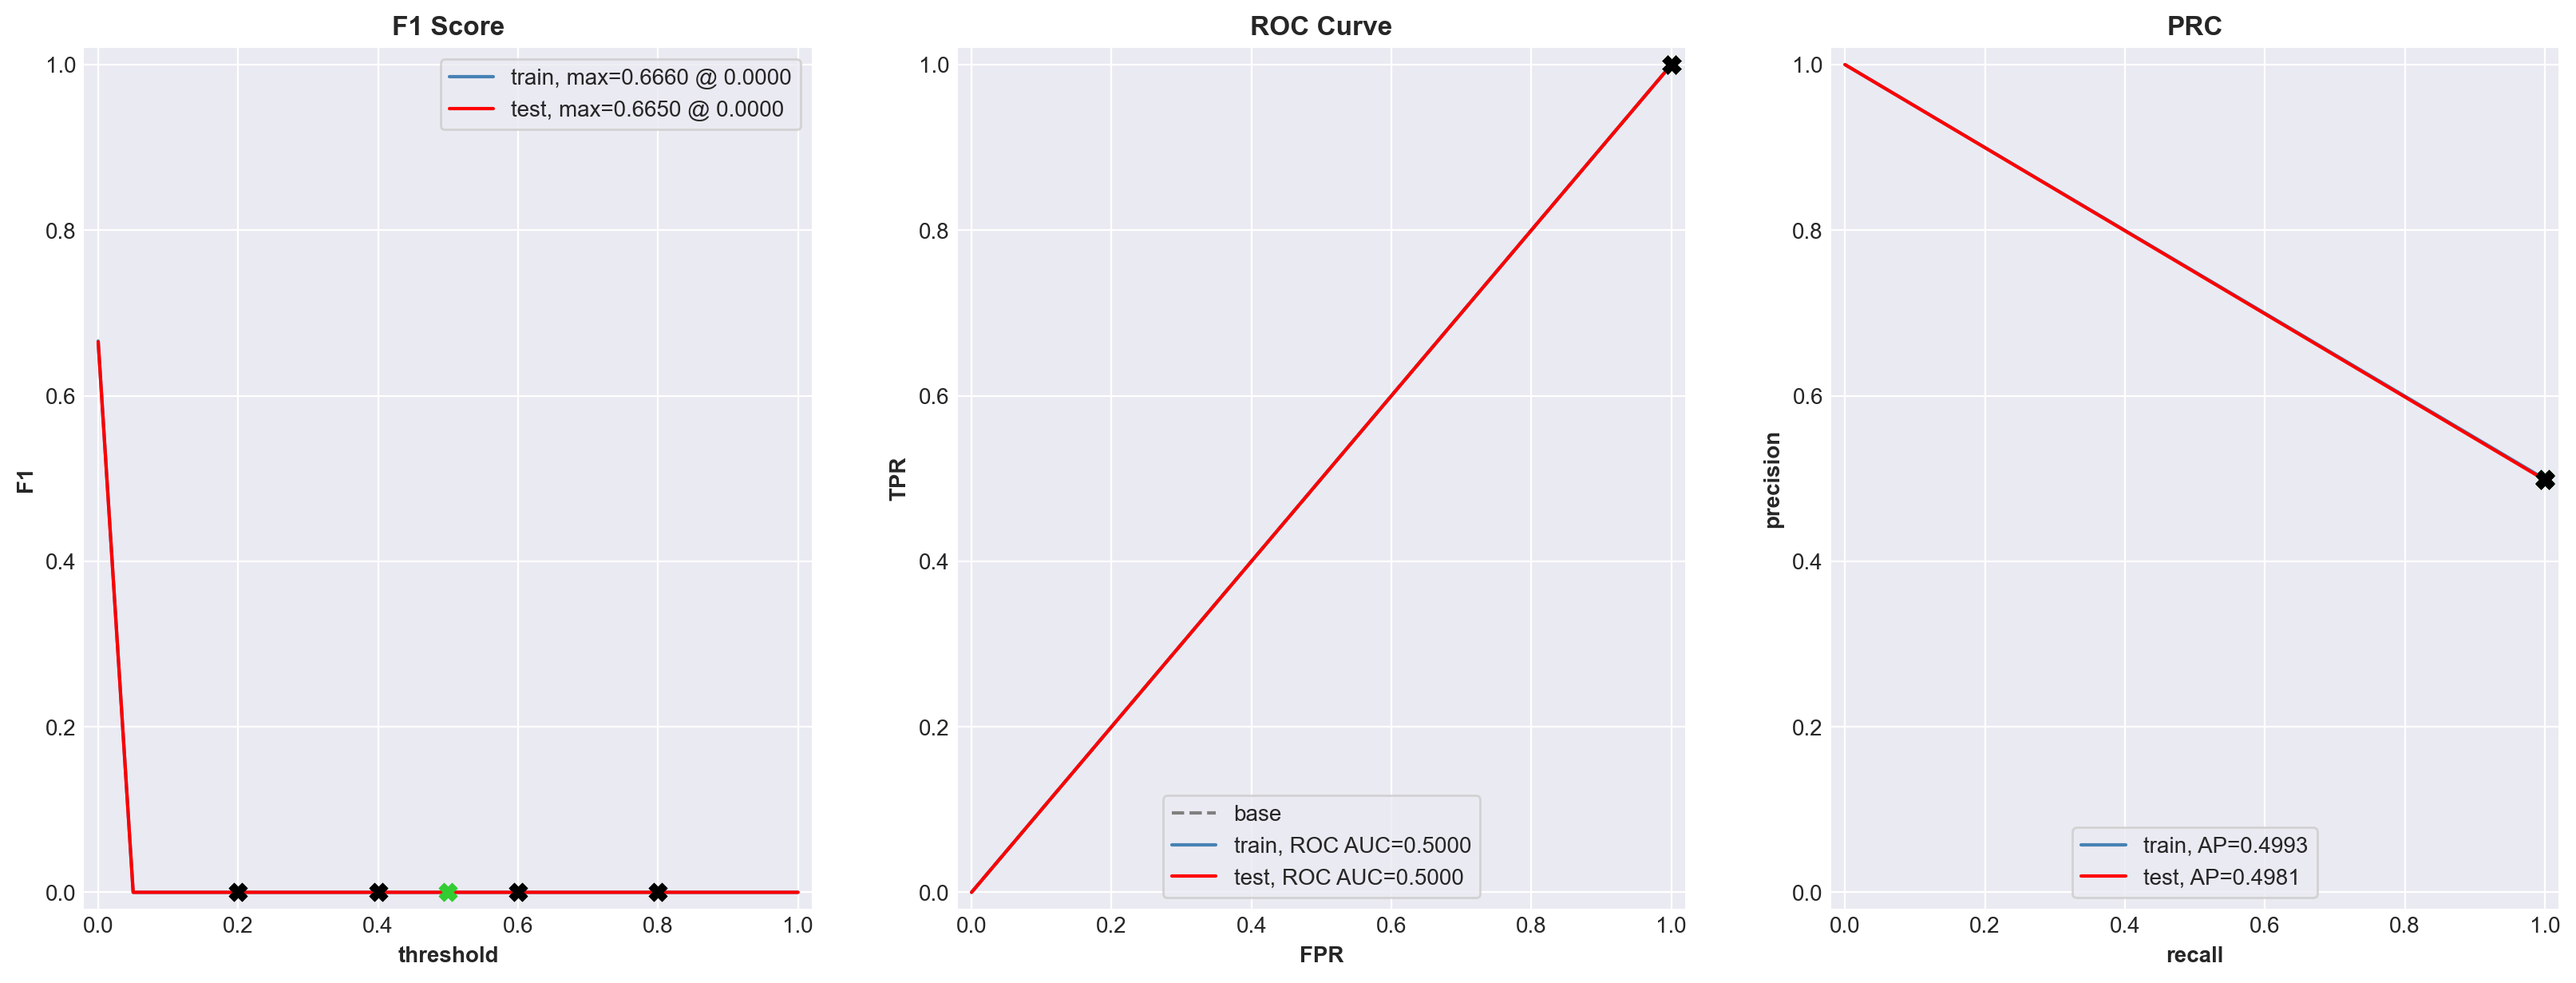

In [41]:
%%time
# evaluate the model
stats = evaluate_model(dummy, X_train, y_train, X_test, y_test)

In [42]:
# store the results to dictionaries
store_results(dummy, 'Dummy Constant', stats = stats)

[Back to Contents](#contents)

## 5.2 Model 1 - NLTK, TF-IDF, and LogR ##
<a id='nltklr'></a>

### 5.2.1 Preprocessing ###
Before constructing the model we must perform text preprocessing. To do this we can perform the following text-cleaning steps:
1. **Tokenization:** Splitting the text into individual words.
2. **Remove Stop Words:** Remove the common words in the text that carry no meaning for the model (the, in, is).
3. **Lemmatization:** Reducing words to their root form to help reduce noise in the data. 

In [43]:
# set stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [44]:
# create preprocessing function
def nltk_text_preprocessing(text):
    # tokenize
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(lemmas)

In [45]:
%%time
# preprocess dataset features
X_train_nltk = X_train.progress_apply(nltk_text_preprocessing)
X_test_nltk = X_test.progress_apply(nltk_text_preprocessing)

  0%|          | 0/23757 [00:00<?, ?it/s]

  0%|          | 0/23483 [00:00<?, ?it/s]

CPU times: total: 8.78 s
Wall time: 40.8 s


### 5.2.2 TF-IDF Vectorization ###

`Term Frequency-Inverse Document Frequency` gives higher importance to words that are frequent in a specific review (or document) but rare across the entire dataset. This helps the model focus on meaningful words. 

We'll use scikit-learn's `TfidVectorizer` to convert the preprocessed reviews into numerical vectors. 

In [46]:
# initiate vectorizer
tfidf_v = TfidfVectorizer()

# fit to training set and transform to both sets
X_train_nltk_idf = tfidf_v.fit_transform(X_train_nltk)
X_test_nltk_idf = tfidf_v.transform(X_test_nltk)

In [47]:
# observe
print('train set shape:')
print('----------------')
print(X_train_nltk_idf.shape, '\n')

print('test set shape:')
print('---------------')
print(X_test_nltk_idf.shape)

train set shape:
----------------
(23757, 97173) 

test set shape:
---------------
(23483, 97173)


### 5.2.3 Logistic Regression Classification ###

In [48]:
logr_search.best_params_

{'solver': 'liblinear',
 'random_state': 12345,
 'penalty': 'l2',
 'n_jobs': -1,
 'max_iter': 280,
 'C': 1.0}

,train,test
Accuracy,0.9357,0.8802
F1,0.9361,0.8799
APS,0.9828,0.9476
ROC AUC,0.9823,0.9501


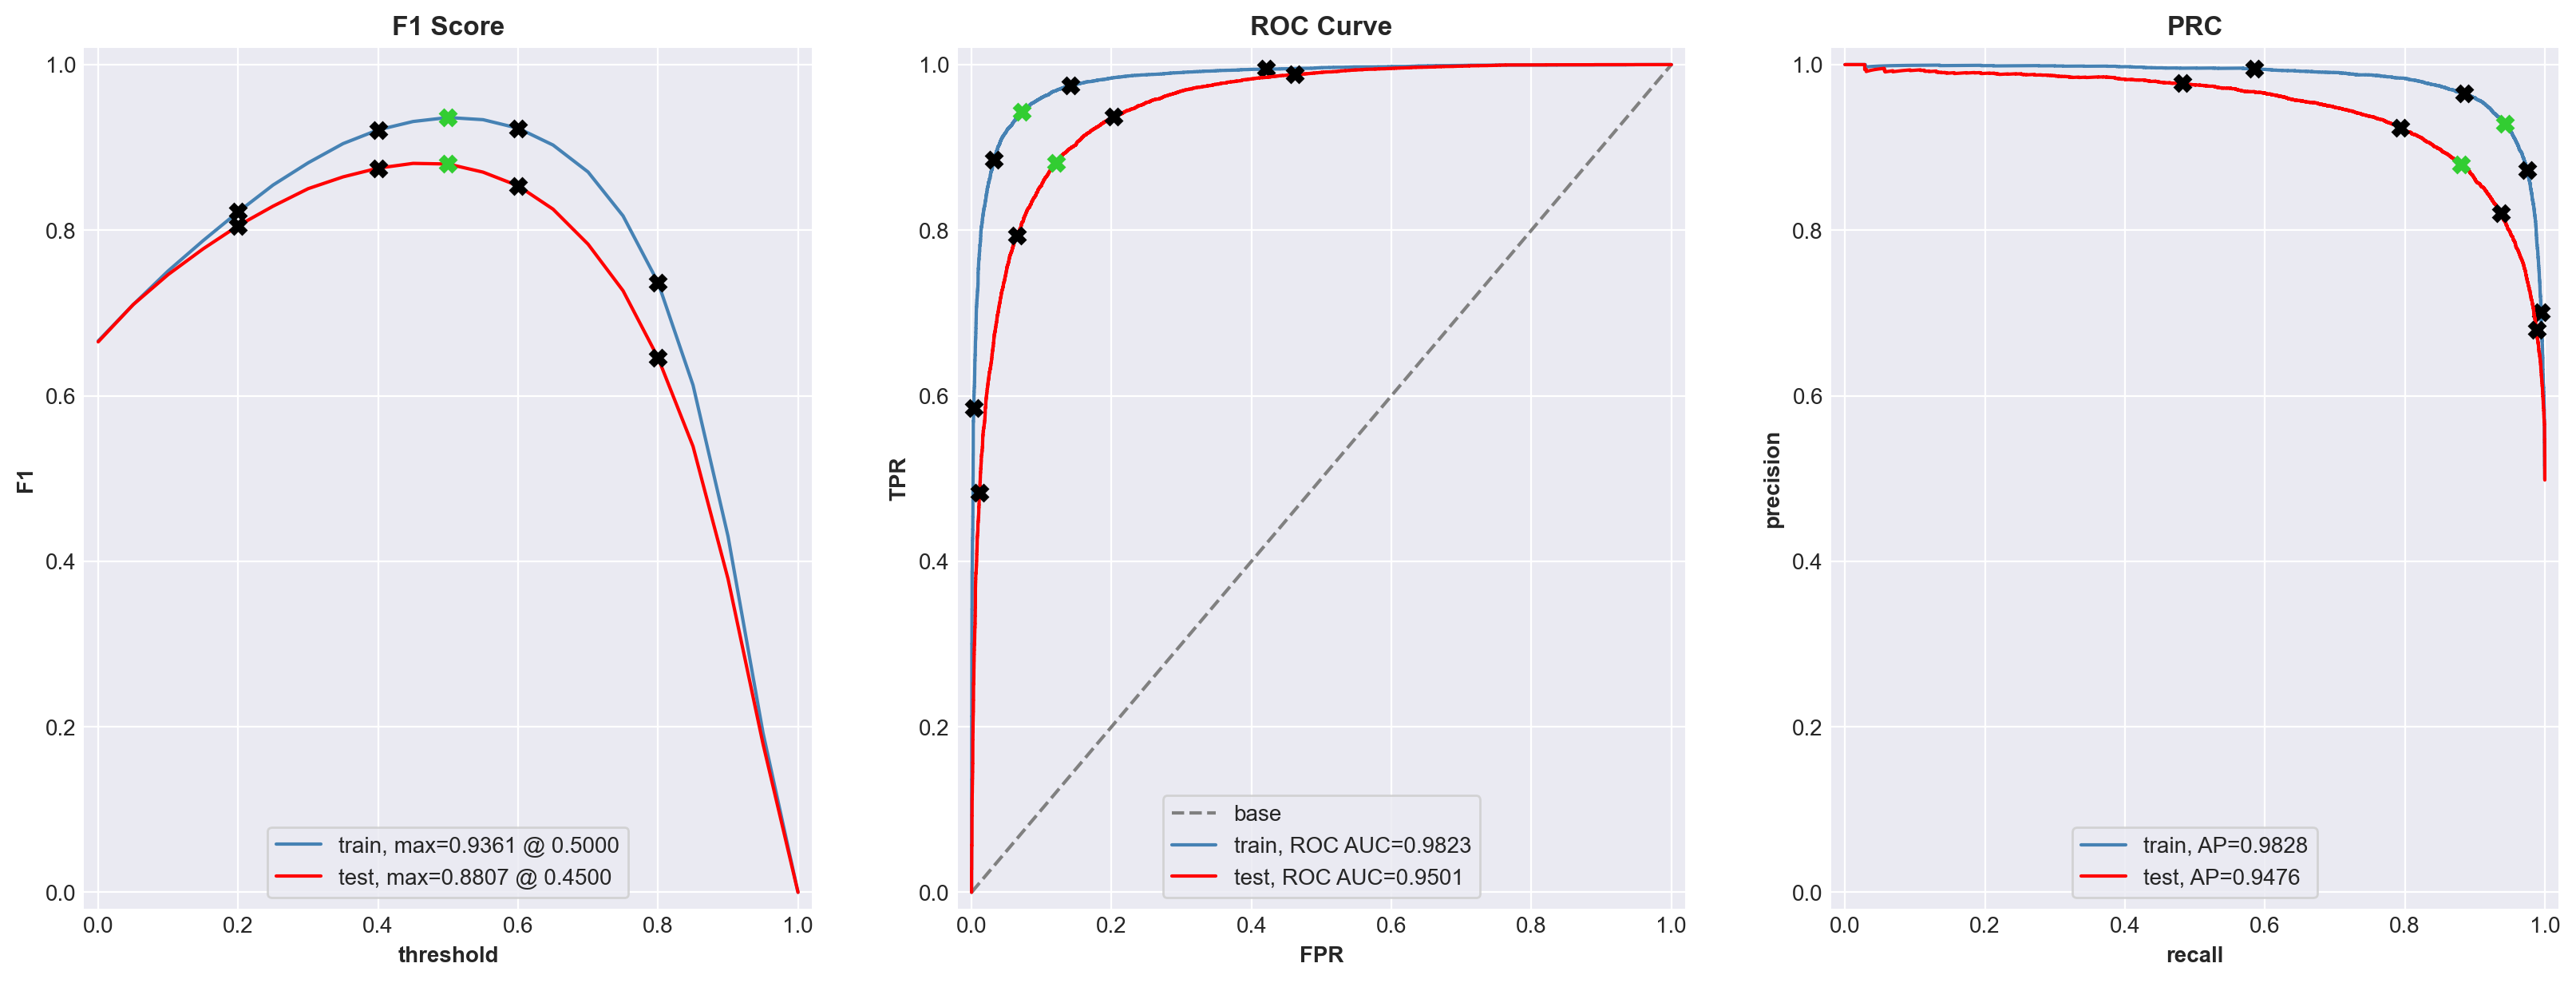

In [49]:
stats = evaluate_model(logr_search, X_train_nltk_idf, y_train, X_test_nltk_idf, y_test)

In [50]:
# save the results
store_results(logr_search, 'NLTK-IDF-LogR', stats = stats)

### 5.2.4 Conclusion ###

Across all three plots, the train and test curves are fairly close, which suggests that the model performs consistently on unseen data but there may be a slight overfitting issue. In addition, the high performance metrics indicate the model performs well in identifying both positive and negative cases accurately. 

**The best F1 score is 0.8802 at a threshold of 0.45 for the NLTK preprocessing method.**

[Back to Contents](#contents)

## 5.3 Model 2 - NLTK, TF-IDF, and LightGBM ##
<a id='nltk_lgbm'></a>

At this point, due to the size of the parameter grids, we will upgrade our optimization method to Bayesian Optimization. Plus, this will be my first time working with it, so a new skill to learn. 

### 5.3.1 LightGBM Classification ###

,train,test
Accuracy,0.9177,0.8571
F1,0.9183,0.8581
APS,0.9749,0.9311
ROC AUC,0.9749,0.9346


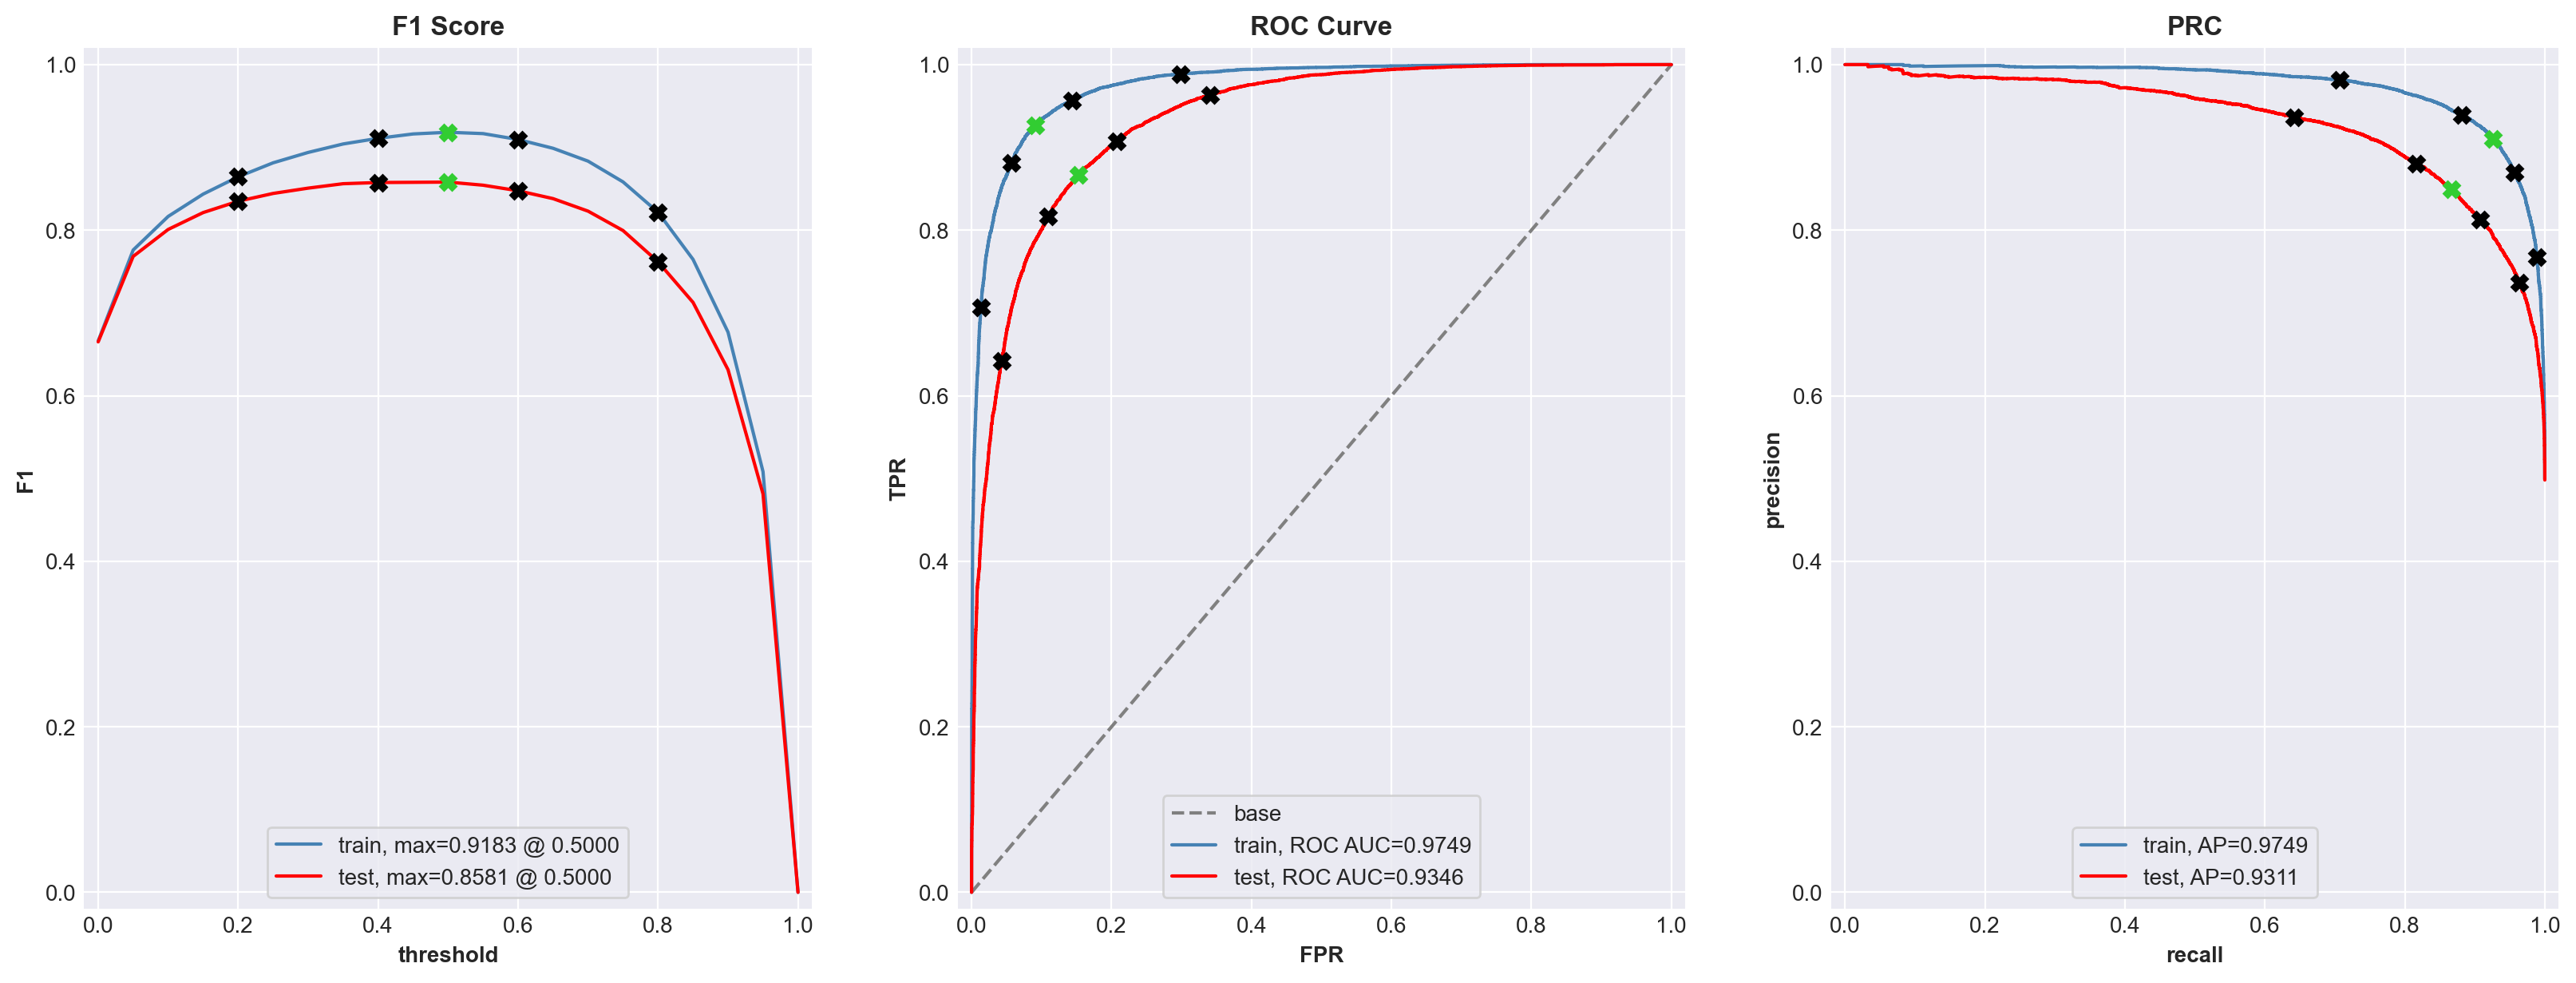

In [51]:
stats = evaluate_model(lgbm_opt, X_train_nltk_idf, y_train, X_test_nltk_idf, y_test)

In [52]:
# store the result
store_results(lgbm_opt, 'NLTK-IDF-LGBM', stats = stats)

### 5.3.2 Conclusion ###

The LightGBM model is outperformed by the Logistic Classifier, and there is more of an obvious overfitting issue. However, the model is not performing poorly due to the high metrics. The addressment of the overfitting was attempted by reducing the ranges among the hyperparameters significacntly, as well as reducing the hyperparameters, the observed result is the best result obtained through these restrictions. 

**The best F1 Score for the NLTK is 0.8581 at a threshold of 0.5 using LightGBM.**

[Back to Contents](#contents)

## 5.4 Model 3 - spaCy, TF-IDF, and LogR ##
<a id='spa-idf'></a>

### 5.4.1 Preprocessing ###

In [53]:
# create spaCy model instance
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

In [54]:
def spacy_preprocessing(text):
    doc = nlp(text)

    lemmas = [token.lemma_ for token in doc]

    return ' '.join(lemmas)

In [55]:
%%time
X_train_spacy = X_train.progress_apply(spacy_preprocessing)
X_test_spacy = X_test.progress_apply(spacy_preprocessing)

  0%|          | 0/23757 [00:00<?, ?it/s]

  0%|          | 0/23483 [00:00<?, ?it/s]

CPU times: total: 8min 1s
Wall time: 8min 45s


*This process took significantly longer using the spaCy model.*

### 5.4.2 TF-IDF Vectorization ###

In [56]:
spacy_tfidf = TfidfVectorizer()

X_train_spacy_idf = spacy_tfidf.fit_transform(X_train_spacy)
X_test_spacy_idf = spacy_tfidf.transform(X_test_spacy)

In [57]:
# observe
print('train set shape:')
print('----------------')
print(X_train_spacy_idf.shape, '\n')

print('test set shape:')
print('---------------')
print(X_test_spacy_idf.shape)

train set shape:
----------------
(23757, 91551) 

test set shape:
---------------
(23483, 91551)


### 5.4.3 Logistic Regression Classification ###

,train,test
Accuracy,0.9256,0.8804
F1,0.9260,0.8802
APS,0.9783,0.9478
ROC AUC,0.9775,0.9496


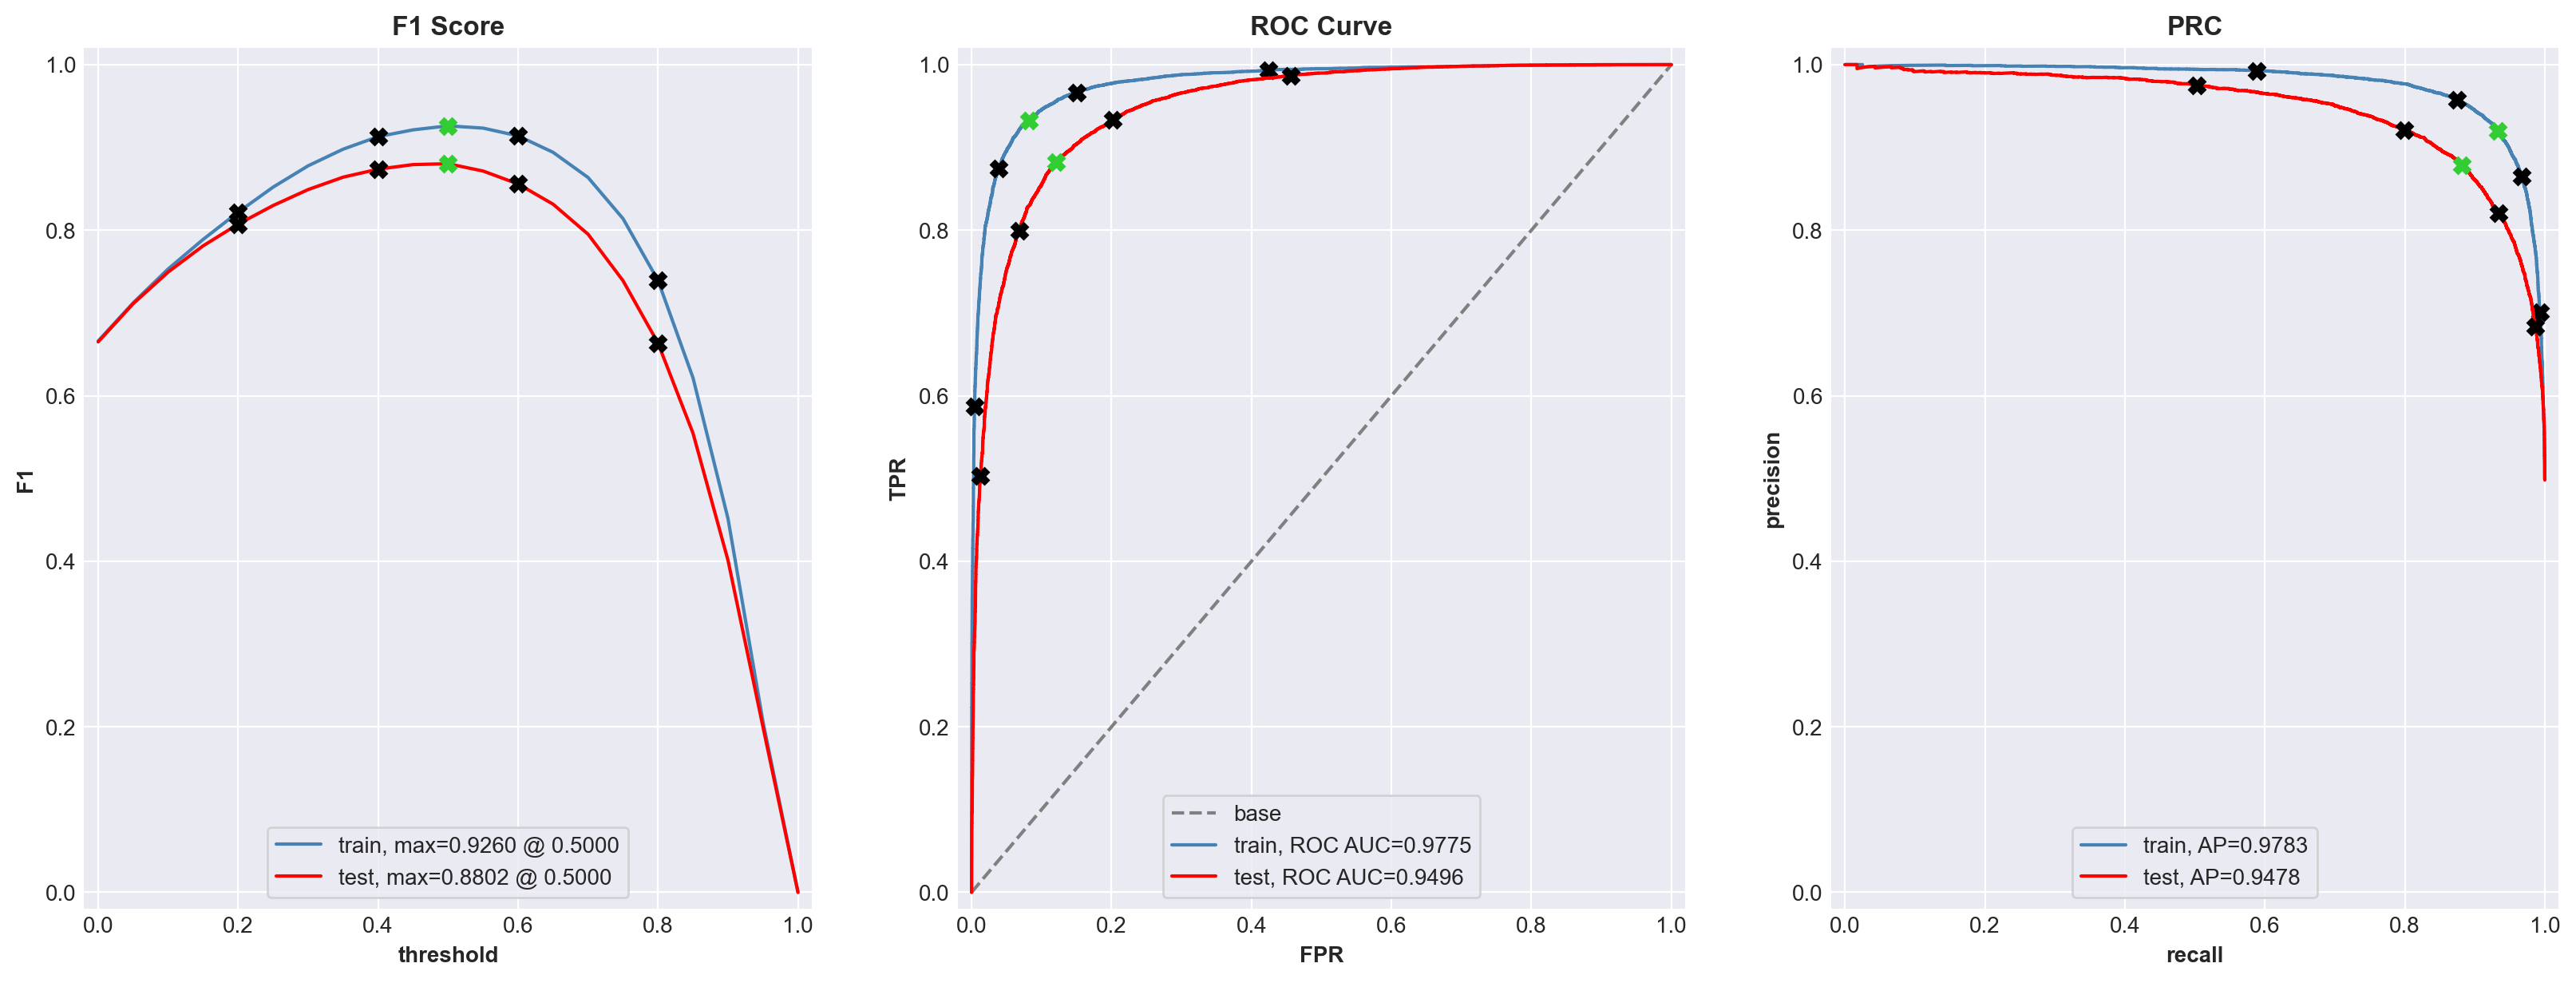

In [58]:
stats = evaluate_model(slogr_opt, X_train_spacy_idf, y_train, X_test_spacy_idf, y_test)

In [59]:
# save the results
store_results(slogr_opt, 'Spacy-IDF-LogR', stats = stats)

### 5.4.4 Conclusion ###

The `spaCy, TF-IDF, and LogR` model converges nicely like the previous logistic regression model and has high metrics. There also appears to be less degree of overfitting when compared to the previous logistic regression model. This model has the **_best performance so far_**, with just a slightly higher score than the `NLTK-IDF-LogR` model. 

**The best F1 Score of 0.8802 occurred at threshold 0.5.**

[Back to Contents](#contents)

## 5.5 Model 4 - spaCy, TF-IDF, and LightGBM ##
<a id='model4'></a>

### 5.5.1 LightGBM Classification ###

Let's try and prevent overfitting further by using a smaller number of estimators and observing the `max_depth` and `num_leaves`.

In [60]:
lgbm_test = LGBMClassifier(n_estimators = 100, n_jobs = -1)
lgbm_test.fit(X_train_spacy_idf, y_train)

[LightGBM] [Info] Number of positive: 11862, number of negative: 11895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471590
[LightGBM] [Info] Number of data points in the train set: 23757, number of used features: 9451
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499305 -> initscore=-0.002778
[LightGBM] [Info] Start training from score -0.002778


LGBMClassifier(n_jobs=-1)

In [61]:
# put the tree data into a DataFrame
tree_info = lgbm_test.booster_.trees_to_dataframe()

min_depth = tree_info['node_depth'].min()
max_depth = tree_info['node_depth'].max()

# Leaves are nodes where `node_index` is not in the `parent_index`
leaves = tree_info[~tree_info['node_index'].isin(tree_info['parent_index'])]
max_leaves = leaves.groupby('tree_index').size().max()

# Print the results
print(f"The minimum depth of the trees is: {min_depth}")
print(f"The maximum depth of the trees is: {max_depth}")
print(f"The maximum number of leaves in any tree is: {max_leaves}")

The minimum depth of the trees is: 1
The maximum depth of the trees is: 31
The maximum number of leaves in any tree is: 31


It appears we should work with a smaller number of leaves and max_depth. Let's adjust our parameter grid. 

,train,test
Accuracy,0.9061,0.8636
F1,0.9070,0.8647
APS,0.9682,0.9364
ROC AUC,0.9679,0.9390


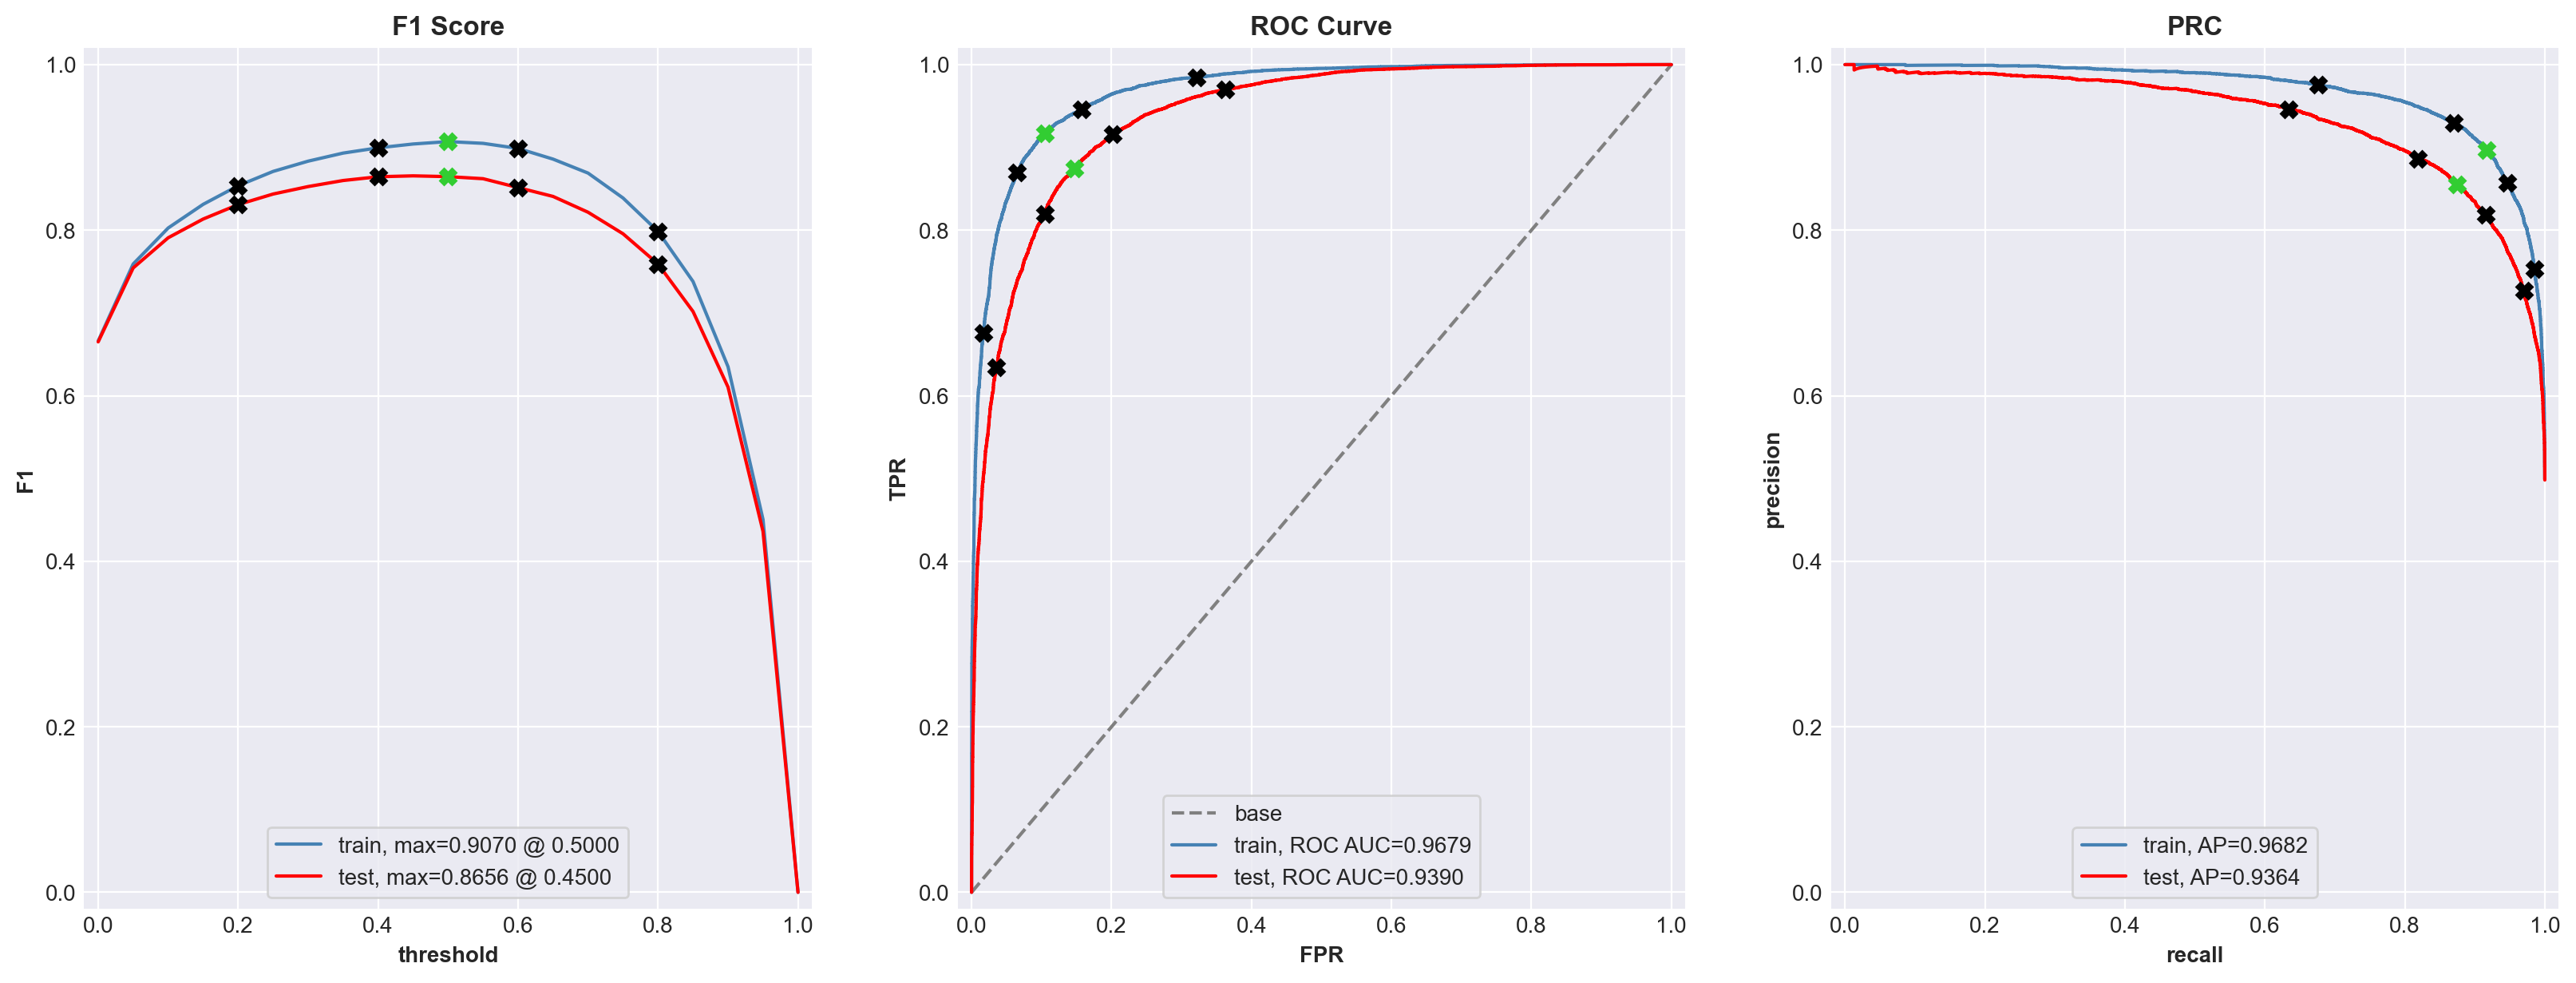

In [62]:
stats = evaluate_model(slgbm_opt, X_train_spacy_idf, y_train, X_test_spacy_idf, y_test)

In [63]:
# store the results
store_results(slgbm_opt, 'Spacy-IDF-LGBM', stats = stats)

### 5.5.2 Conclusion ###

The `Spacy-IDF-LGBM` model outperforms the `NLTK-IDF-LGBM` model by a decent margin, but does not outperform either logistic regression models. We have successfully reduced the overfitting when compared to the previous LGBM model; I believe this could be reduced further, but this current model meets the qualifications of the project and still converges similarly with high metrics. 

**The best F1 Score was 0.8656 at threshold 0.45 for the Spacy-IDF-LGBM model.**

## 5.6 Model 5 - BERT LogR ##
<a id='model5'></a>

In [64]:
# ensure GPU will be used
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 4090


### 5.6.1 Preprocessing ###

In [65]:
# Initialize tokenizer, config settings, and model
BERT_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
BERT_config = transformers.BertConfig.from_pretrained('bert-base-uncased')
BERT_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [66]:
def BERT_text_to_embeddings(texts, 
                            max_length = 512, 
                            batch_size = 100,
                            force_device = None,
                            disable_progress_bar = False):
    '''
    Function to convert texts to embeddings with BERT model.
    '''
    
    ids_list = []
    attention_mask_list = []

    for text in texts:
        # convert text into numerical IDs
        ids = BERT_tokenizer.encode(text,
                                    max_length = max_length,
                                    truncation = True,
                                    add_special_tokens = True)

        # ensure each token sequence is same length
        # pad shorter than 512 with 0s
        padded = np.pad(ids, (0, max_length - len(ids)))

        # store the ids
        ids_list.append(padded)

        attention_mask = np.where(padded != 0, 1, 0)
        attention_mask_list.append(attention_mask)
    # end loop

    # debugging
    #print({len(seq) for seq in ids_list})

    # option to force GPU
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    BERT_model.to(device)

    # option to remove progress bar
    if not disable_progress_bar:
        print(f"Using the {device} device.")

    # create embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), 
                  disable = disable_progress_bar): # for each batch

        # convert to pytorch 
        ids_batch = torch.LongTensor(
            np.array(ids_list[batch_size * i : batch_size * (i+1)])
        ).to(device)

        attention_mask_batch = torch.LongTensor(
            np.array(attention_mask_list[batch_size * i: batch_size * (i+1)])
        ).to(device)

        # disable gradients for faster processing
        with torch.no_grad():
            BERT_model.eval()
            batch_embeddings = BERT_model(input_ids = ids_batch, 
                                     attention_mask = attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

### 5.6.2 Training ###

In [67]:
%%time
X_train_bert = BERT_text_to_embeddings(X_train, force_device = 'cuda')
X_test_bert = BERT_text_to_embeddings(X_test, force_device = 'cuda')

Using the cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/235 [00:00<?, ?it/s]

CPU times: total: 24min 52s
Wall time: 4min 22s


In [68]:
# observe
print('train set shape:')
print('----------------')
print(X_train_bert.shape, '\n')

print('test set shape:')
print('---------------')
print(X_test_bert.shape)

train set shape:
----------------
(23757, 768) 

test set shape:
---------------
(23483, 768)


### 5.6.3 Logisitic Regression Classification ###

In [72]:
%%time
blogr = LogisticRegression()

blogr_grid = {
    'C': (0.001, 1.0, 'log-uniform'),
    'max_iter': (10, 100),
    'n_jobs': [-1],
    'random_state': [12345]
}

blogr_opt = BayesSearchCV(
    estimator = blogr,
    search_spaces = blogr_grid,
    n_iter = 50,
    scoring = 'f1',
    cv = 5,
    n_jobs = -1,
    random_state = 12345
)

blogr_opt.fit(X_train_bert, y_train)

CPU times: total: 6min 46s
Wall time: 2min 19s


BayesSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
              random_state=12345, scoring='f1',
              search_spaces={'C': (0.001, 1.0, 'log-uniform'),
                             'max_iter': (10, 100), 'n_jobs': [-1],
                             'random_state': [12345]})

,train,test
Accuracy,0.8722,0.8628
F1,0.8713,0.8608
APS,0.9442,0.9354
ROC AUC,0.9437,0.9361


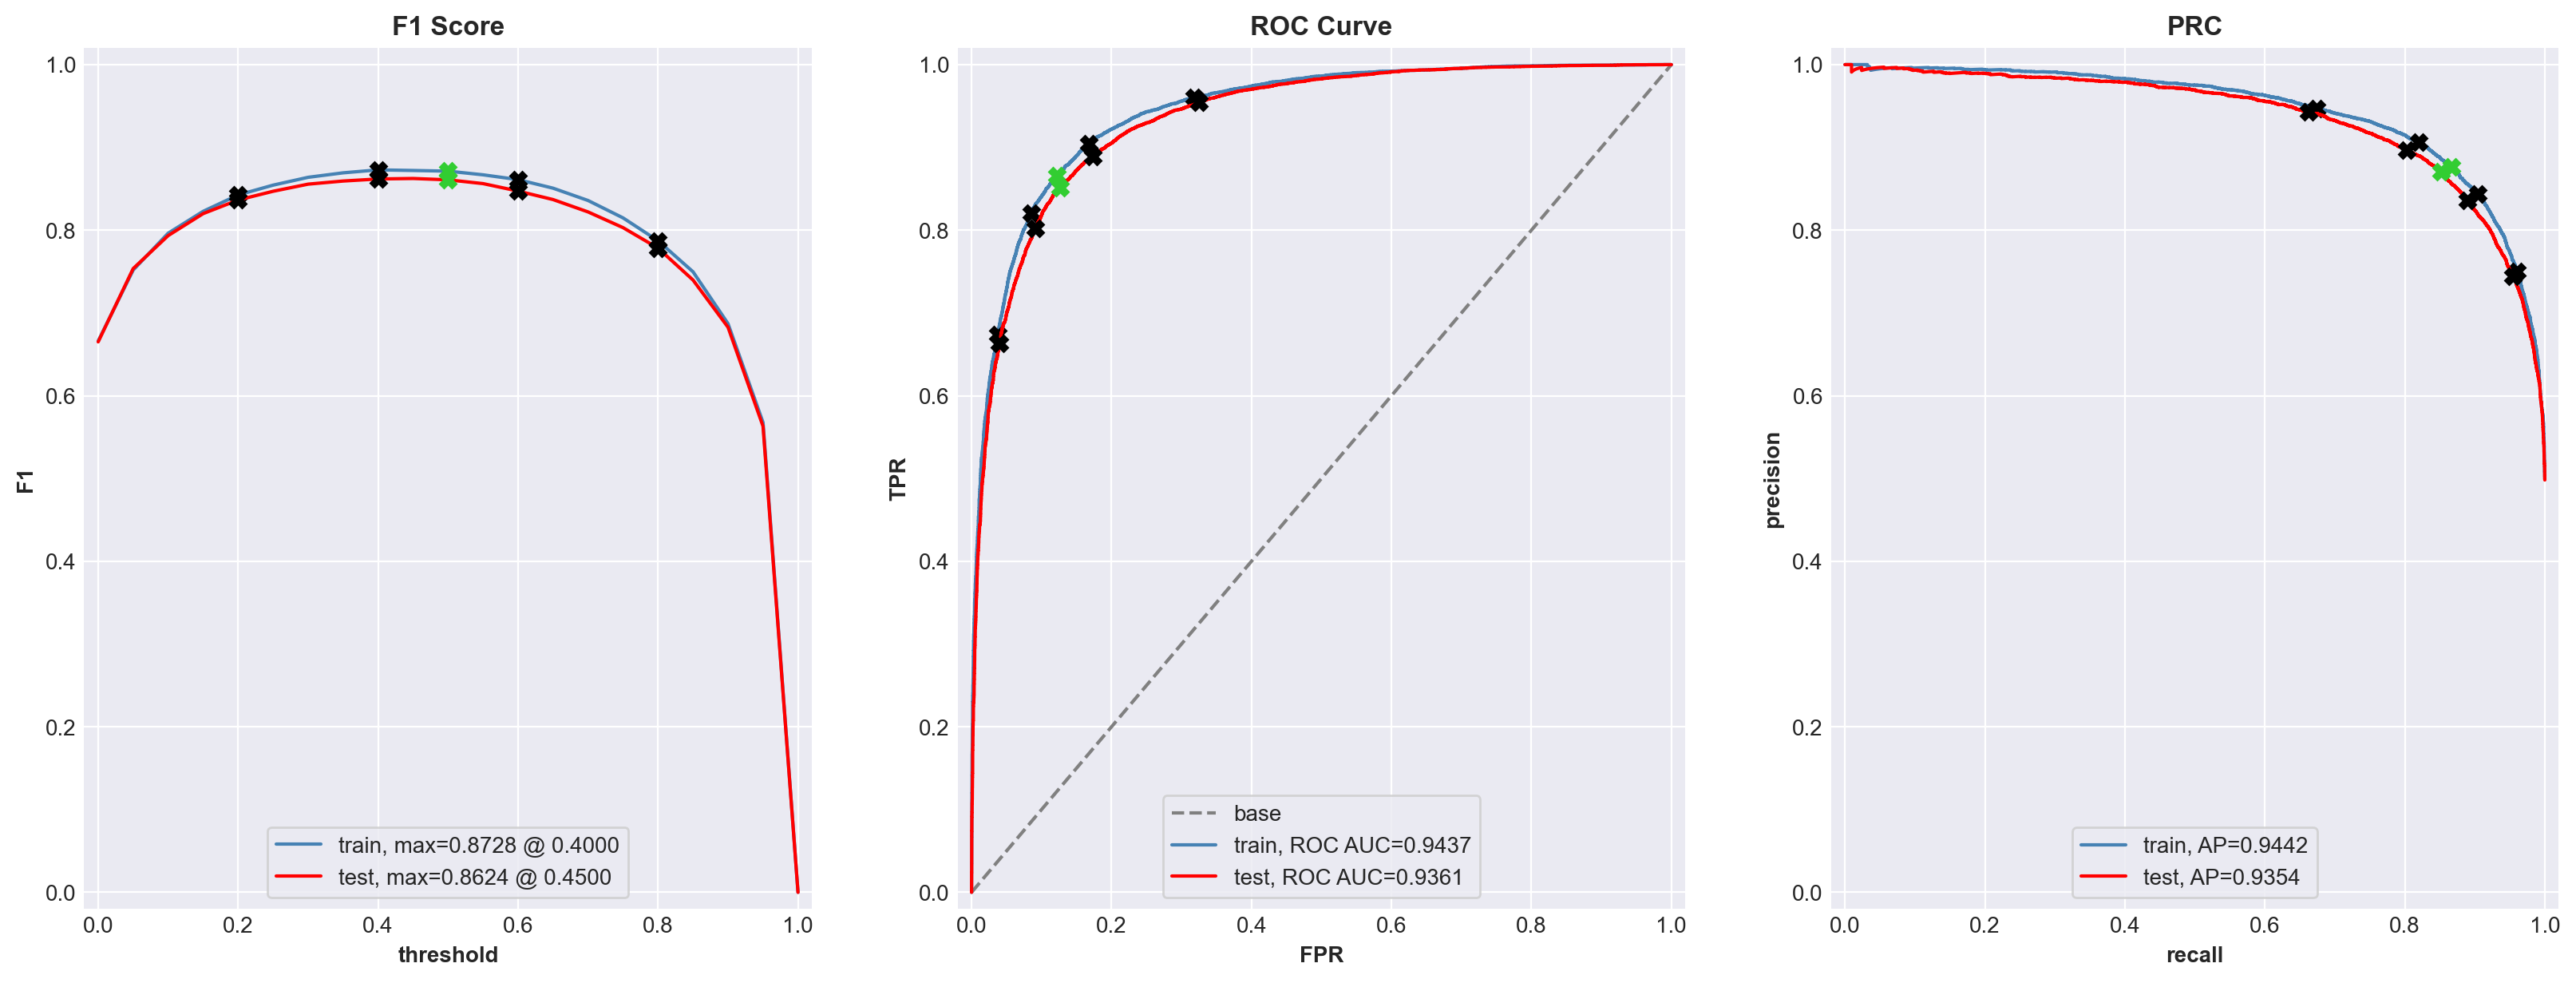

In [73]:
stats = evaluate_model(blogr_opt, X_train_bert, y_train, X_test_bert, y_test)

In [74]:
# save the results
store_results(blogr_opt, 'BERT-LogR', stats = stats)

### 5.6.4 Conclusion ###

The `BERT LogR` model clearly has no overfitting issues as compared to the other models. It is the most consistent model on unseen data as the curves are the closest, but it is not the most accurate as was expected for the BERT model. The `BERT LogR` model performs better than the `NLTK-IDF-LGBM` and `Dummy Constant` models, placing it in the bottom half of best performing models tested so far. 

**The best F1 Score of 0.8624 occurred at threshold 0.45.**

[Back to Contents](#contents)

## 5.7 Model 6 - BERT LightGBM ##
<a id='model6'></a>

### 5.7.1 LightGBM Classification ###

In [76]:
%%time
blgbm = LGBMClassifier()

blgbm_grid = {
    'learning_rate': (0.001, 1.0, 'log-uniform'),
    'n_estimators': (10, 100),
    'max_depth': (3, 10),
    'num_leaves': (2, 10),
    'reg_alpha': (0.001, 100, 'log-uniform'),
    'reg_lambda': (0.001, 100, 'log-uniform'),
    'subsample': (0.5, 0.8),
    'colsample_bytree': (0.4, 0.8),
    'random_state': [42],
    'n_jobs': [-1]
}

blgbm_opt = BayesSearchCV(
    estimator = blgbm,
    search_spaces = blgbm_grid,
    n_iter = 32,
    scoring = 'f1',
    cv = 5,
    n_jobs = -1,
    random_state = 12345
)

blgbm_opt.fit(X_train_bert, y_train)

[LightGBM] [Info] Number of positive: 11862, number of negative: 11895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23757, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499305 -> initscore=-0.002778
[LightGBM] [Info] Start training from score -0.002778
CPU times: total: 5min 42s
Wall time: 1min 48s


BayesSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=32, n_jobs=-1,
              random_state=12345, scoring='f1',
              search_spaces={'colsample_bytree': (0.4, 0.8),
                             'learning_rate': (0.001, 1.0, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (10, 100),
                             'n_jobs': [-1], 'num_leaves': (2, 10),
                             'random_state': [42],
                             'reg_alpha': (0.001, 100, 'log-uniform'),
                             'reg_lambda': (0.001, 100, 'log-uniform'),
                             'subsample': (0.5, 0.8)})

,train,test
Accuracy,0.8764,0.8305
F1,0.8761,0.8298
APS,0.9507,0.9113
ROC AUC,0.9495,0.9115


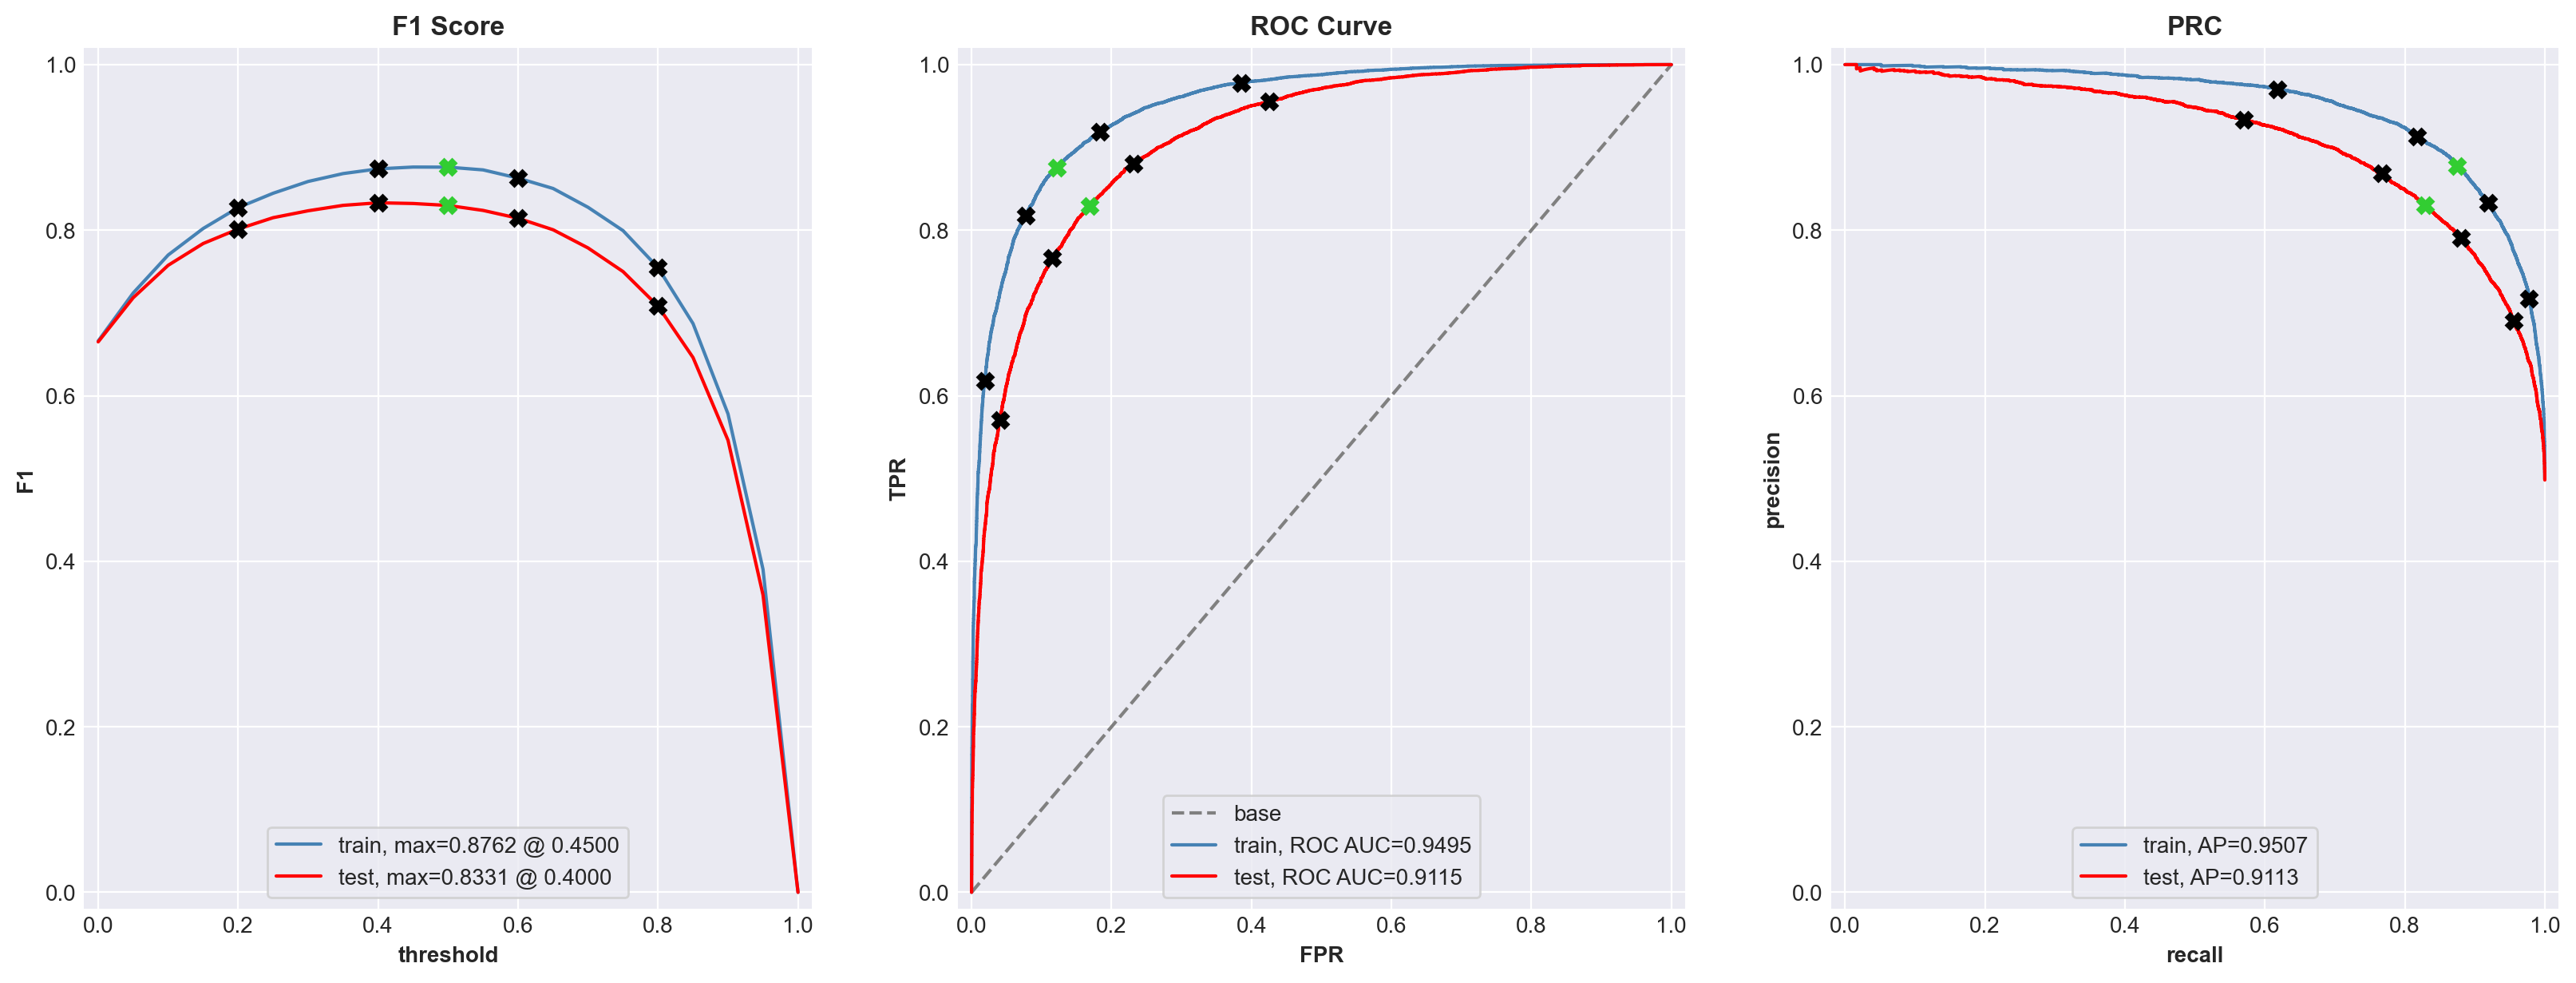

In [77]:
stats = evaluate_model(blgbm_opt, X_train_bert, y_train, X_test_bert, y_test)

In [91]:
# store the results
store_results(blgbm_opt, 'BERT-LGBM', stats = stats)

### 5.7.2 Conclusion ###

The `BERT-LGBM` is the second worst performin model of the ones we tested, not reaching the minimum of 0.85 F1 Score for the project requirements. There is minor evidence of overfitting by the graphs, but still obtains decent metrics overall and good consistency. The F1 score for this model can actually be improved if overfitting the data, but that leads to more variance in longterm performance. I'm confident this version of the model would be more stable long-term. 

**The BERT-LGBM model's highest F1 Score was 0.8331 at a threshold of 0.4.**

[Back to Contents](#contents)

## 5.8 Final Results ##
<a id='final'></a>

In [79]:
# create final dataframe - this was challenging
results_data = {}

for model_name in results.keys():
    # initialize a sub-dict for each model
    results_data[model_name] = {}
    
    for metric_name in results[model_name].index:
        results_data[model_name][f"{metric_name} Train"] = results[model_name].loc[metric_name, 'train']
        results_data[model_name][f"{metric_name} Test"] = results[model_name].loc[metric_name, 'test']
        #print(results_data)

results_df = pd.DataFrame.from_dict(
    results_data, orient = 'index').sort_values(by = 'F1 Test', ascending = False)

# observe
results_df

,Accuracy Train,Accuracy Test,F1 Train,F1 Test,APS Train,APS Test,ROC AUC Train,ROC AUC Test
Spacy-IDF-LogR,0.9256,0.8804,0.9260,0.8802,0.9783,0.9478,0.9775,0.9496
NLTK-IDF-LogR,0.9357,0.8802,0.9361,0.8799,0.9828,0.9476,0.9823,0.9501
Spacy-IDF-LGBM,0.9061,0.8636,0.9070,0.8647,0.9682,0.9364,0.9679,0.9390
BERT-LogR,0.8722,0.8628,0.8713,0.8608,0.9442,0.9354,0.9437,0.9361
NLTK-IDF-LGBM,0.9177,0.8571,0.9183,0.8581,0.9749,0.9311,0.9749,0.9346
BERT-LGBM,0.8764,0.8305,0.8761,0.8298,0.9507,0.9113,0.9495,0.9115
Dummy Constant,0.5007,0.5019,0.0000,0.0000,0.4993,0.4981,0.5000,0.5000


Our best performing model was the `Spacy-IDF-LogR` model with an F1 score of 0.8802 on the test set. The BERT models were surprisingly in the bottom half of top-performing models. All models performed better than the baseline. This is not to say BERT is a poor model, there were not many models tested, we could easily spend more time testing various other models with BERT and the other strategies. 

All models meet the requirements of the project except for the `BERT-LGBM` model; however, we could have gotten very close if severely overfitted on purpose. 

[Back to Contents](#contents)

# 6. Custom Reviews #
<a id='reviews'></a>
_________________________________________________________________________________________________________________________________________________________

To put our hard-working models to use we will test each one on custom-written reviews to see how they perform. 

## 6.1 My Custom Reviews ##

The goal for writing my own reviews is as follows:
- 1 vague review
- 3 obviously positive
- 3 obviously negative
- 1 slightly obviously positive
- 1 slightly obviously negative

In [110]:
my_reviews = pd.DataFrame([
    "You know, I didn't hate it, but I didn't love it. I'm overall confused, it was alright.",
    "I found this to be a complete derailment from the traditional material. Garbage.",
    "I really liked this movie, it made my body feel warm and fuzzy. I must make a phone call now.",
    "It exceeded all my expectations and lit a fire within me.",
    "This movie reminded me of having to pick up dog poop on an hourly basis.",
    "I didn't expect to see a dumpster fire this catastrophic.",
    "Tense and creepy, Hugh Grants performance was pitch perfect. Loved it.",
    "the movie is completely unfaithful to the game. i dont understand why they didnt get anything right. Not enough words can be said about this. ",
    "This movie is fun I don’t really care what anyone else says.",
    "This film is a cinematic magnum opus. It is a triumphant celebration of the cinematic art with gorgeous interplay of color, music, atmosphere, character build-up, dialogue, story, and suspense. 10 out of 10 recommended"
], columns = ['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize)
my_reviews['pos'] = [1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
my_reviews

  0%|          | 0/10 [00:00<?, ?it/s]

,review,review_norm,pos
0,"You know, I didn't hate it, but I didn't love ...",you know i didnt hate it but i didnt love it i...,1
1,I found this to be a complete derailment from ...,i found this to be a complete derailment from ...,0
2,"I really liked this movie, it made my body fee...",i really liked this movie it made my body feel...,1
3,It exceeded all my expectations and lit a fire...,it exceeded all my expectations and lit a fire...,1
4,This movie reminded me of having to pick up do...,this movie reminded me of having to pick up do...,0
5,I didn't expect to see a dumpster fire this ca...,i didnt expect to see a dumpster fire this cat...,0
6,"Tense and creepy, Hugh Grants performance was ...",tense and creepy hugh grants performance was p...,1
7,the movie is completely unfaithful to the game...,the movie is completely unfaithful to the game...,0
8,This movie is fun I don’t really care what any...,this movie is fun i dont really care what anyo...,1
9,This film is a cinematic magnum opus. It is a ...,this film is a cinematic magnum opus it is a t...,1


## 6.2 Model 1 - NLTK, TF-IDF, LogR ##

In [111]:
model_1 = best_model['NLTK-IDF-LogR']
texts = my_reviews['review_norm']

my_reviews_X = tfidf_v.transform(texts.apply(nltk_text_preprocessing))
my_reviews_pred_prob = model_1.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.36: you know i didnt hate it but i didnt love it im overall confused it was alright
0.15: i found this to be a complete derailment from the traditional material garbage
0.64: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
0.41: it exceeded all my expectations and lit a fire within me
0.46: this movie reminded me of having to pick up dog poop on an hourly basis
0.42: i didnt expect to see a dumpster fire this catastrophic
0.96: tense and creepy hugh grants performance was pitch perfect loved it
0.19: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.50: this movie is fun i dont really care what anyone else says
0.78: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 7/10 reviews correct. 

## 6.3 Model 2 - NLTK, TF-IDF, LGBM ##

In [112]:
model_2 = best_model['NLTK-IDF-LGBM']
texts = my_reviews['review_norm']

my_reviews_X = tfidf_v.transform(texts.apply(nltk_text_preprocessing))
my_reviews_pred_prob = model_2.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.44: you know i didnt hate it but i didnt love it im overall confused it was alright
0.44: i found this to be a complete derailment from the traditional material garbage
0.58: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
0.59: it exceeded all my expectations and lit a fire within me
0.56: this movie reminded me of having to pick up dog poop on an hourly basis
0.64: i didnt expect to see a dumpster fire this catastrophic
0.93: tense and creepy hugh grants performance was pitch perfect loved it
0.41: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.84: this movie is fun i dont really care what anyone else says
0.79: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 7/10 correct

## 6.4 Model 3 - spaCy, IDF, LogR ##

In [113]:
model_3 = best_model['Spacy-IDF-LogR']
texts = my_reviews['review_norm']

my_reviews_X = spacy_tfidf.transform(texts.apply(spacy_preprocessing))
my_reviews_pred_prob = model_3.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.66: you know i didnt hate it but i didnt love it im overall confused it was alright
0.17: i found this to be a complete derailment from the traditional material garbage
0.59: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
0.69: it exceeded all my expectations and lit a fire within me
0.39: this movie reminded me of having to pick up dog poop on an hourly basis
0.34: i didnt expect to see a dumpster fire this catastrophic
0.97: tense and creepy hugh grants performance was pitch perfect loved it
0.09: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.39: this movie is fun i dont really care what anyone else says
0.77: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 9/10 correct

## 6.5 Model 4 - spaCy, IDF, LGBM ##

In [114]:
model_4 = best_model['Spacy-IDF-LGBM']
texts = my_reviews['review_norm']

my_reviews_X = spacy_tfidf.transform(texts.apply(spacy_preprocessing))
my_reviews_pred_prob = model_4.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.70: you know i didnt hate it but i didnt love it im overall confused it was alright
0.44: i found this to be a complete derailment from the traditional material garbage
0.74: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
0.69: it exceeded all my expectations and lit a fire within me
0.60: this movie reminded me of having to pick up dog poop on an hourly basis
0.54: i didnt expect to see a dumpster fire this catastrophic
0.93: tense and creepy hugh grants performance was pitch perfect loved it
0.27: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.58: this movie is fun i dont really care what anyone else says
0.76: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 8/10 correct

## 6.6 Model 5 - BERT LogR ##

In [115]:
model_5 = best_model['BERT-LogR']
texts = my_reviews['review_norm']

my_reviews_X = BERT_text_to_embeddings(texts, disable_progress_bar = True)
my_reviews_pred_prob = model_5.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.91: you know i didnt hate it but i didnt love it im overall confused it was alright
0.74: i found this to be a complete derailment from the traditional material garbage
0.72: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
1.00: it exceeded all my expectations and lit a fire within me
0.83: this movie reminded me of having to pick up dog poop on an hourly basis
0.20: i didnt expect to see a dumpster fire this catastrophic
0.99: tense and creepy hugh grants performance was pitch perfect loved it
0.07: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.56: this movie is fun i dont really care what anyone else says
0.97: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 8/10 correct. But it's confidence percentages were more decisive. 

## 6.7 Model 6 - BERT LGBM ##

In [116]:
model_6 = best_model['BERT-LGBM']
texts = my_reviews['review_norm']

my_reviews_X = BERT_text_to_embeddings(texts, disable_progress_bar = True)
my_reviews_pred_prob = model_6.predict_proba(my_reviews_X)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}: {review}")

0.72: you know i didnt hate it but i didnt love it im overall confused it was alright
0.45: i found this to be a complete derailment from the traditional material garbage
0.53: i really liked this movie it made my body feel warm and fuzzy i must make a phone call now
0.82: it exceeded all my expectations and lit a fire within me
0.42: this movie reminded me of having to pick up dog poop on an hourly basis
0.38: i didnt expect to see a dumpster fire this catastrophic
0.76: tense and creepy hugh grants performance was pitch perfect loved it
0.06: the movie is completely unfaithful to the game i dont understand why they didnt get anything right n
0.32: this movie is fun i dont really care what anyone else says
0.91: this film is a cinematic magnum opus it is a triumphant celebration of the cinematic art with gorgeo


Model got 7/10 correct.

[Back to Contents](#contents)

# Overall Conclusion #
<a id='conclusion'></a>
_________________________________________________________________________________________________________________________________________________________

**_Data Exploration & Preprocessing_**

The dataset contained 47,331 reviews along with other related information. We extensively searched for implicit anamolous/missing values with no implicit findings, but did determine there were 91 duplicate reviews which were dropped. 

**_EDA_**

The following patterns were observed:
- The number of movies remained on a steady trend of less than 50 until 1968, and then the number of unique movies per year increased 1992. Afterwards there was almost epontential growth in the number of movies until 2006. There was an identical trend for the number of reviews per year.
- Starting in the 1990s, there is an increasing trend in the amount of negative reviews.
- `Drama` and `Comedy` are the most popular genres by a decent margin.
    - Movies with more positive reviews have higher ratings, so `Drama` and `Comedy` had more postive reviews than negative. 
- `Horror` movies have the largest ratio of negative reviews to postive reviews.
- `Action, Thriller, Horror, and Sci-Fi` genres all have more negative reviews than positive.
- There were no reviews with a rating of 5 or 6. Reviews tend to not be bimodal.
- The distributions between the train and test sets are identical for number of reviews and for ratings.
- The distributions of the target classes between the train and test sets are identical.

**_Model Development_**

The reviews were preprocessed via text normalization by converting all text to lowercase and removing all punctuation and special characters. The reviews were then further processed by one of three different models: NLTK and TF-IDF, spaCy and TF-IDF, or BERT. For each process, two ML models were trained and developed: Logistic Regression and LGBM.

**_Model Evaluation_**
- The main evaluation metric for this project was the `F1 Score`. Other metrics were observed which included accuracy, precision-recall, and ROC-AUC.
- All of the models except for the baseline (_constant_) and `BERT-LGBM` achieved an `F1 Score` of at least 0.85 as required per our instructions.
- The Logistic Regression models were generally faster than the others.
- The BERT models tended to have bipolar prediction probabilities compared to the other models which, in some cases, rarely had a low or high probability; whereas the BERT models are more confident in their predictions show very low or very high prediction probabilities.
- The **spaCy-IDF-LogR** model was the best performing model with an `F1 Score` of **0.8802.**
    - When testing this model on self-written reviews, it scored a 9/10, and I wrote some purposefully tricky reviews.

# Appendix A - Saving Models #
<a id='appendix_a'></a>
_________________________________________________________________________________________________________________________________________________________

Run the code below when you need to resave the models or add new ones to save. 